In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization
from hloc import colmap_for_habitat, triangulation, localize_sfm, visualization
import h5py
import os
import numpy as np
from collections import defaultdict
import pycolmap
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import math
import g2o
from enum import Enum
import cv2
from threading import Lock
from hloc.utils.parsers import (
    parse_image_lists_with_intrinsics, parse_retrieval, names_to_pair)
from tqdm import tqdm
import json

[07/10/2021 21:36:12 INFO] Generating new fontManager, this may take some time...


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [2]:
dataset = Path('/datasets/Habitat/')
images_path = dataset / 'extracted_HPointLoc'

outputs = Path('/datasets/Habitat/Hierarchical_Localization_outputs/sfm/')
# sfm_pairs = outputs / 'pairs_exhaustive_base-around.txt'
# sfm_pairs = outputs / 'pairs_exhaustive.txt'
sfm_dir = outputs / 'sfm_superpoint+superglue'
# sfm_pairs = dataset / 'NetVLAD/NetVLAD_database.txt' 
loc_pairs = dataset / 'ORB+DBOW2/scores_DBoW2_all_maps.txt'  # top 50 retrieved by NetVLAD

feature_conf = extract_features.confs['superpoint_habitat']
matcher_conf = match_features.confs['superglue']

features = feature_conf['output']
feature_filename = f"{features}.h5"
match_filename = f"{features}_{matcher_conf['output']}_{sfm_pairs.stem}.h5"
reference_sfm = outputs / 'sfm_superpoint+superglue'  # the SfM model we will build

results = outputs / 'Habitat_hloc_superpoint+superglue_hfnet_top_3.txt'  # the result file

In [3]:
cx, cy = 128, 128
fx, fy = 128, 128
width, height = 256., 256.
fx_baseline = 300

## Extract local features

In [16]:
extract_features.main(feature_conf, images_path, outputs)

[06/21/2021 12:28:55 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1024-nms4',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
Loaded SuperPoint model
[06/21/2021 12:29:00 INFO] Found 86678 images in root /datasets/Habitat/extracted_HPointLoc.


100%|██████████| 86678/86678 [16:48<00:00, 85.96it/s]  


[06/21/2021 12:45:50 INFO] Finished exporting features.


## Matching pairs in database with SuperGlue

In [ ]:
match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [9]:
match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[06/29/2021 08:45:35 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


  0%|          | 0/76063 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 76063/76063 [44:46<00:00, 28.32it/s]

[06/29/2021 09:30:22 INFO] Finished exporting matches.


## Exhaustive match images

In [34]:
exhaustive_pairs = outputs / 'pairs_exhaustive.txt'  # exhaustive matching

In [36]:
match_features.main(matcher_conf, exhaustive_pairs, feature_conf['output'], outputs, exhaustive=True)

[06/07/2021 08:12:10 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[06/07/2021 08:12:10 INFO] Writing exhaustive match pairs to /datasets/Habitat/Hierarchical_Localization_outputs/sfm/pairs_exhaustive.txt.
Loaded SuperGlue model ("outdoor" weights)


 12%|█▏        | 68573/591328 [46:10<5:52:01, 24.75it/s] 


KeyboardInterrupt: 

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [ ]:
localize_sfm.main(
    reference_sfm / 'model',
    dataset / 'query_with_intrinsics.txt',
    loc_pairs,
    outputs / f"{feature_conf['output']}.h5",
    outputs / f"{feature_conf['output']}_{matcher_conf['output']}_{loc_pairs.stem}.h5",
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

In [ ]:
visualization.visualize_loc(
    results, images, reference_sfm / 'model', n=100, top_k_db=1, prefix='', seed=2)

## Visualization

In [ ]:
f = sfm_pairs.open()
lines = f.readlines()
filename1 = images / Path(lines[0].split(' ')[0])
filename2 = images / Path(lines[1].split(' ')[1].rstrip('\n'))

### Visualization of matched keypoints without RANSAC

In [ ]:
f = sfm_pairs.open()
lines = f.readlines()
filename1 = images / Path(lines[0].split(' ')[0])
filename2 = images / Path(lines[1].split(' ')[1].rstrip('\n'))

In [ ]:
for i in range(10):
    line = lines[i]
    print(line)
    filename1 = images / Path(line.split(' ')[0])
    filename2 = images / Path(line.split(' ')[1].rstrip('\n'))
    visualization.visualize_matches(outputs / feature_file, 
                                outputs / match_file, 
                                images, 
                                filename1, filename2, dpi=100)

### Visualization using SfM model of the map
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='visibility', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='track_length', n=5)

In [ ]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', images, color_by='depth', n=5)

# Implementing optimizationon selected images

In [397]:
cx, cy = 128, 128
fx, fy = 128, 128
width, height = 256., 256.
ransac_thresh = 12.0

In [31]:
def quaternion_to_rotation_matrix(qvec):
    r = R.from_quat([qvec[1], qvec[2], qvec[3], qvec[0]])
    result = r.as_matrix()
    result[:3,2] = -result[:3,2]
    result[:3,1] = -result[:3,1]
    return result

In [32]:
def get_point_3d(x, y, depth, fx, fy, cx, cy, cam_center_world, R_world_to_cam, w_in_quat_first = True):
    if depth <= 0:
        return [0]
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    if len(R_world_to_cam) == 4:
        if w_in_quat_first:
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
        else:
            R_world_to_cam = [R_world_to_cam[3], R_world_to_cam[0], R_world_to_cam[1], R_world_to_cam[2]]
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
    elif len(R_world_to_cam) == 3:
        matrix = R_world_to_cam
    coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
    return coord_3D_cam_to_world

In [400]:
def names_to_pair(name0, name1):
    return '_'.join((name0.replace('/', '-'), name1.replace('/', '-')))

In [401]:
def yaw_pitch_roll_from_quaternion(quaternion, w_first=False):
    if not(w_first):
        r = R.from_quat(quaternion)
    else:
        r = R.from_quat([quaternion[1], quaternion[2], quaternion[3] ,quaternion[0]])
    return r.as_euler('yxz', degrees=True)

In [402]:
def yaw_pitch_roll_from_matrix(matrix):
    r = R.from_matrix(matrix)
    return(r.as_euler('yxz', degrees=True))

In [445]:
# query_image = '1LXtFkjw3qL_point12_query_0001'
# db_image = '1LXtFkjw3qL_point16_database_0000'

query_image = '1LXtFkjw3qL_point12_query_0007'
db_image = '1LXtFkjw3qL_point16_query_0038'

is_database_for_image1 = ""
is_database_for_image2 = ""
if query_image.find('database') != -1:
    is_database_for_image1 = "_base"
if db_image.find('database') != -1:
    is_database_for_image2 = "_base"
path_to_hdf5_datasets = '/datasets/Habitat/1LXtFkjw3qL_point0/hdf5/'
hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
num_query = int(query_image.split('_')[-1])
num_db = int(db_image.split('_')[-1])

In [446]:
keypoints_file = h5py.File(str(outputs / feature_filename), 'r')
match_filename = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_HF_Net_qdb_qdb.h5'
match_file = h5py.File(str(outputs / match_filename), 'r')

In [447]:
keypoints_query = keypoints_file[query_image.rstrip('.png')]['keypoints'].__array__()
keypoints_db = keypoints_file[db_image.rstrip('.png')]['keypoints'].__array__()

In [448]:
images = {}
images['query'] = {}
images['db'] = {}
images['query']['points_3d'] = []
images['db']['points_3d'] = []
points_3D = {}
point_3D_id = 0
image_id = 1
depth_db = 10*hdf5_file_db['depth'+is_database_for_image2][num_db]
cam_xyz_db = hdf5_file_db['gps'+is_database_for_image2][num_db]
R_cam_db = hdf5_file_db['quat'+is_database_for_image2][num_db]
# R_cam_db = [1,0,0,0]
# cam_xyz_db = [0,0,0]
for keypoint in keypoints_db:
    depth_keypoint = depth_db[int(keypoint[1]), int(keypoint[0])][0]
    point_3d_xyz = get_point_3d(keypoint[0], keypoint[1], depth_keypoint, fx, fy, cx, cy, cam_xyz_db, R_cam_db)
    if len(point_3d_xyz) != 1:
        if (math.isnan(depth_keypoint)) or (math.isinf(depth_keypoint)):
            images['db']['points_3d'].append(-1)
            continue
        else:
            images['db']['points_3d'].append(point_3D_id)
            points_3D[point_3D_id] = {}
            points_3D[point_3D_id]['xyz'] = point_3d_xyz
            if not('image_ids' in points_3D[point_3D_id].keys()):
                points_3D[point_3D_id]['image_ids'] = []
            if points_3D[point_3D_id]['image_ids'].count(image_id) == 0:
                points_3D[point_3D_id]['image_ids'] = [image_id]
            else:
                points_3D[point_3D_id]['image_ids'].append(image_id)
            point_3D_id += 1
    else:
        images['db']['points_3d'].append(-1)

image_id = 2
depth_query = 10*hdf5_file_query['depth'+is_database_for_image1][num_query]
cam_xyz = hdf5_file_query['gps'+is_database_for_image1][num_query]
R_cam = hdf5_file_query['quat'+is_database_for_image1][num_query]
print(cam_xyz)
print(R_cam)
for keypoint in keypoints_query:
    depth_keypoint = depth_query[int(keypoint[1]), int(keypoint[0])][0]
    point_3d_xyz = get_point_3d(keypoint[0], keypoint[1], depth_keypoint, fx, fy, cx, cy, cam_xyz, R_cam)
    if len(point_3d_xyz) != 1:
        if (math.isnan(depth_keypoint)) or (math.isinf(depth_keypoint)):
            images['query']['points_3d'].append(-1)
        else:
            images['query']['points_3d'].append(point_3D_id)
        points_3D[point_3D_id] = {}
        points_3D[point_3D_id]['xyz'] = point_3d_xyz
        if not('image_ids' in points_3D[point_3D_id].keys()):
            points_3D[point_3D_id]['image_ids'] = []
        if points_3D[point_3D_id]['image_ids'].count(image_id) == 0:
            points_3D[point_3D_id]['image_ids'] = [image_id]
        else:
            points_3D[point_3D_id]['image_ids'].append(image_id)
        point_3D_id += 1
    else:
        images['query']['points_3d'].append(-1)
# print(len(keypoints_query))

[-2.6726573 -0.3934288  6.7047086]
[-0.99388444  0.         -0.11042551  0.        ]


## G2O

In [4]:
class BundleAdjustment(g2o.SparseOptimizer):
    def __init__(self, delta=np.sqrt(5.991), gain_threshold=1e-6):
        super().__init__()

        # Higher confident (better than CHOLMOD, according to 
        # paper "3-D Mapping With an RGB-D Camera")
        solver = g2o.BlockSolverSE3(g2o.LinearSolverCSparseSE3())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)
        super().set_verbose(True)

        # Convergence Criterion
        terminate = g2o.SparseOptimizerTerminateAction()
#         terminate.set_gain_threshold(1e-6)
        terminate.set_gain_threshold(gain_threshold)
        super().add_post_iteration_action(terminate)

        # Robust cost Function (Huber function) delta
#         self.delta = np.sqrt(5.991) 
        self.delta = delta
        self.aborted = False

    def optimize(self, max_iterations=10 ):
        super().initialize_optimization()
        super().optimize(max_iterations)
        try:
            return not self.aborted
        finally:
            self.aborted = False

    def add_pose(self, pose_id, pose, cam, fixed=False):
        sbacam = g2o.SBACam(
            pose.orientation(), pose.position())
        sbacam.set_cam(
            cam.fx, cam.fy, cam.cx, cam.cy, cam.baseline)

        v_se3 = g2o.VertexCam()
        v_se3.set_id(pose_id * 2)
        v_se3.set_estimate(sbacam)
        v_se3.set_fixed(fixed)
        super().add_vertex(v_se3) 

    def add_point(self, point_id, point, fixed=False, marginalized=True):
        v_p = g2o.VertexSBAPointXYZ()
        v_p.set_id(point_id * 2 + 1)
        v_p.set_marginalized(marginalized)
        v_p.set_estimate(point)
        v_p.set_fixed(fixed)
        super().add_vertex(v_p)

    def add_edge(self, id, point_id, pose_id, meas):
        if meas.is_stereo():
            edge = self.stereo_edge(meas.xyx)
        elif meas.is_left():
            edge = self.mono_edge(meas.xy)
        elif meas.is_right():
            edge = self.mono_edge_right(meas.xy)

        edge.set_id(id)
        edge.set_vertex(0, self.vertex(point_id * 2 + 1))
        edge.set_vertex(1, self.vertex(pose_id * 2))
        kernel = g2o.RobustKernelHuber(self.delta)
        edge.set_robust_kernel(kernel)
        super().add_edge(edge)

    def stereo_edge(self, projection, information=np.identity(3)):
        e = g2o.EdgeProjectP2SC()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def mono_edge(self, projection, 
            information=np.identity(2) * 0.5):
        e = g2o.EdgeProjectP2MC()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def mono_edge_right(self, projection, 
            information=np.identity(2) * 0.5):
        e = g2o.EdgeProjectP2MCRight()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def get_pose(self, id):
        return self.vertex(id * 2).estimate()

    def get_point(self, id):
        return self.vertex(id * 2 + 1).estimate()

    def abort(self):
        self.aborted = True

In [5]:
class Camera(object):
    def __init__(self, fx, fy, cx, cy, width, height, baseline):
        self.fx = fx
        self.fy = fy
        self.cx = cx
        self.cy = cy
        self.baseline = baseline

        self.intrinsic = np.array([
            [fx, 0, cx], 
            [0, fy, cy], 
            [0, 0, 1]])

#         self.frustum_near = frustum_near
#         self.frustum_far = frustum_far

        self.width = width
        self.height = height
        
    def compute_right_camera_pose(self, pose):
        pos = pose * np.array([self.baseline, 0, 0])
        return g2o.Isometry3d(pose.orientation(), pos)

In [6]:
class GraphMeasurement(object):
    def __init__(self):
        self.keyframe = None
        self.mappoint = None

    @property
    def id(self):
        return (self.keyframe.id, self.mappoint.id)

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, rhs):
        return (isinstance(rhs, GraphMeasurement) and
            self.id == rhs.id)

In [7]:
class Measurement(GraphMeasurement):
    
    Source = Enum('Measurement.Source', ['TRIANGULATION', 'TRACKING', 'REFIND'])
    Type = Enum('Measurement.Type', ['STEREO', 'LEFT', 'RIGHT'])

    def __init__(self, type, source, keypoints):
        super().__init__()

        self.type = type
        self.source = source
        self.keypoints = keypoints
        self.view = None    # mappoint's position in current coordinates frame

        self.xy = np.array(self.keypoints[0].pt)
        if self.is_stereo():
            self.xyx = np.array([
                *keypoints[0].pt, keypoints[1].pt[0]])

        self.triangulation = (source == self.Source.TRIANGULATION)

    def get_keypoint(self, i=0):
        return self.keypoints[i]

    def get_keypoints(self):
        return self.keypoints

    def is_stereo(self):
        return self.type == Measurement.Type.STEREO
    def is_left(self):
        return self.type == Measurement.Type.LEFT
    def is_right(self):
        return self.type == Measurement.Type.RIGHT

    def from_triangulation(self):
        return self.triangulation
    def from_tracking(self):
        return self.source == Measurement.Source.TRACKING
    def from_refind(self):
        return self.source == Measurement.Source.REFIND

In [8]:
class GraphMapPoint(object):
    def __init__(self):
        self.id = None
        self.meas = dict()
        self._lock = Lock()

    def __hash__(self):
        return self.id

    def __eq__(self, rhs):
        return (isinstance(rhs, GraphMapPoint) and 
            self.id == rhs.id)
    def __lt__(self, rhs):
        return self.id < rhs.id
    def __le__(self, rhs):
        return self.id <= rhs.id

    def measurements(self):
        with self._lock:
            return self.meas.keys()

    def keyframes(self):
        with self._lock:
            return self.meas.values()

    def add_measurement(self, m):
        with self._lock:
            self.meas[m] = m.keyframe

    def remove_measurement(self, m):
        with self._lock:
            try:
                del self.meas[m]
            except KeyError:
                pass

In [9]:
class MapPoint(GraphMapPoint):
    _id = 0
    _id_lock = Lock()

    def __init__(self, position, covariance=np.identity(3) * 1e-4):
        super().__init__()

        with MapPoint._id_lock:
            self.id = MapPoint._id
            MapPoint._id += 1

        self.position = position
        self.covariance = covariance
        # self.owner = None

        self.count = defaultdict(int)

    def update_position(self, position):
        self.position = position
    def update_normal(self, normal):
        self.normal = normal
    def update_descriptor(self, descriptor):
        self.descriptor = descriptor
    def set_color(self, color):
        self.color = color

    def is_bad(self):
        with self._lock:
            status =  (
                self.count['meas'] == 0
                or (self.count['outlier'] > 20
                    and self.count['outlier'] > self.count['inlier'])
                or (self.count['proj'] > 20
                    and self.count['proj'] > self.count['meas'] * 10))
            return status

    def increase_outlier_count(self):
        with self._lock:
            self.count['outlier'] += 1
    def increase_inlier_count(self):
        with self._lock:
            self.count['inlier'] += 1
    def increase_projection_count(self):
        with self._lock:
            self.count['proj'] += 1
    def increase_measurement_count(self):
        with self._lock:
            self.count['meas'] += 1

In [10]:
fx, fy = 128., 128.
cx, cy = 128., 128.
width, height = 256, 256
fx_baseline = 300
baseline = fx_baseline/fx
cam = Camera(
    fx, fy, cx, cy, 
    width, height, 
    baseline)

### Optimization

In [456]:
# pair = names_to_pair(query_image, db_image)
# matches = match_file[pair]['matches0'].__array__()
# valid = np.where(matches > -1)[0]
# # valid - массив точек на query изображении, которые имеют сопоставление

In [457]:
import faiss
from sklearn.metrics.pairwise import cosine_similarity
import torch
from hloc.utils.base_model import dynamic_load
from hloc import matchers
confs = {
    'superglue': {
        'output': 'matches-superglue',
        'model': {
            'name': 'superglue',
            'weights': 'outdoor',
            'sinkhorn_iterations': 50,
        },
    },
    'NN': {
        'output': 'matches-NN-mutual-dist.7',
        'model': {
            'name': 'nearest_neighbor',
            'mutual_check': True,
            'distance_threshold': 0.7,
        },
    }
}

conf = confs['superglue']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Model = dynamic_load(matchers, conf['model']['name'])
model = Model(conf['model']).eval().to(device)

data = {}
feats0, feats1 = keypoints_file[query_image], keypoints_file[db_image]
for k in feats1.keys():
    data[k+'0'] = feats0[k].__array__()
for k in feats1.keys():
    data[k+'1'] = feats1[k].__array__()
data = {k: torch.from_numpy(v)[None].float().to(device)
        for k, v in data.items()}
data['image0'] = torch.empty((1, 1,)+tuple(feats0['image_size'])[::-1])
data['image1'] = torch.empty((1, 1,)+tuple(feats1['image_size'])[::-1])
        
pred = model(data)
        
matches = pred['matches0'][0].cpu().short().numpy()
valid = np.where(matches > -1)[0]

Loaded SuperGlue model ("outdoor" weights)


In [460]:
# For Query image

data = {
    'points_db'   : [],
    'points_g2o'  : [],
    'points_query': []
}

optimizer = BundleAdjustment(delta=np.sqrt(5.991), gain_threshold=1e-7)
optimizer.clear()
pose_44 = np.eye(4)
R_cam = quaternion_to_rotation_matrix(hdf5_file_db['quat'+is_database_for_image2][num_db])


pose_44[:3,:3] = quaternion_to_rotation_matrix(hdf5_file_db['quat'+is_database_for_image2][num_db])
pose_44[:3,3] = hdf5_file_db['gps'+is_database_for_image2][num_db]
pose = g2o.Isometry3d(pose_44)
optimizer.add_pose(0, pose, cam, fixed=False)
measurements = []
for i, keypoint_xy_query in enumerate(keypoints_query):
    # Если кипоинт не имеет сопоставления, то пропускаем его
    if list(valid).count(i) == 0:
        continue
    # Получим индекс соответствующего кипоинта на database изображении
    kp_idx_db = matches[i]
    # Получим индекс point 3D, соответствующий индексу ключевой точки kp_idx_db
    point_3D_id_db = images['db']['points_3d'][kp_idx_db]
#     point_3D_id_query = images['query']['points_3d'][i]
    
    point_xyz_db    = points_3D[point_3D_id_db]['xyz']
#     point_xyz_query = points_3D[point_3D_id_query]['xyz']
    
#     data['points_db'].append(point_xyz_db.tolist())
#     data['points_query'].append(point_xyz_query.tolist())
    
    x_right = keypoint_xy_query[0] - fx_baseline/(depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0])
    kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
    kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
    kp_right.pt = (x_right, keypoint_xy_query[1])
    
    meas = Measurement(Measurement.Type.STEREO,
                       Measurement.Source.TRIANGULATION,
                       [kp_left, kp_right])
    mappoint = MapPoint(point_xyz_db)
    meas.mappoint = mappoint
    measurements.append(meas)

In [461]:
for i, m in enumerate(measurements):
    optimizer.add_point(i, m.mappoint.position, fixed=True)
    optimizer.add_edge(0, i, 0, m)

In [470]:
optimizer.optimize(50)
result = optimizer.get_pose(0)
pose_estimated = result.matrix()

r = R.from_matrix(result.matrix()[:3,:3])
yaw_pitch_roll = r.as_euler('yxz', degrees=True)

print('g2o result:')
print(result.position())
print(yaw_pitch_roll)
print()
cam_xyz = hdf5_file_query['gps'+is_database_for_image1][num_query]
pose_query = np.eye(4)
pose_query[:3,3] = cam_xyz
pose_query[:3,:3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'+is_database_for_image1][num_query])
print('query gt:')
print(cam_xyz)
r = R.from_matrix(pose_query[:3,:3])
yaw_pitch_roll = r.as_euler('yxz', degrees=True)
print(yaw_pitch_roll)
print()
cam_xyz_db = hdf5_file_db['gps'+is_database_for_image2][num_db]
r = R.from_matrix(quaternion_to_rotation_matrix(hdf5_file_db['quat'+is_database_for_image2][num_db]))
yaw_pitch_roll = r.as_euler('yxz', degrees=True)

# pose_estimated = np.eye(4)
# pose_estimated[:3,3] = cam_xyz_db
# pose_estimated[:3,:3] = r.as_matrix()

print('db pose:')
print(cam_xyz_db)
print(yaw_pitch_roll)

error_pose = np.linalg.inv(pose_estimated) @ pose_query
dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
r = R.from_matrix(error_pose[:3, :3])
rotvec = r.as_rotvec()
angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
angle_error = abs(180 - abs(angle_error-180))
print()
print('distance error - {}'.format(dist_error))
print('angle error - {}'.format(angle_error))
print('pose:')
print(result.matrix())
data['cam_pose_g2o'] = result.matrix().tolist()

g2o result:
[-3.39710121 -0.29589647  6.87235104]
[ 169.02006587    0.92122149 -178.73090694]

query gt:
[-2.6726573 -0.3934288  6.7047086]
[167.32031072   0.         180.        ]

db pose:
[-2.806292  -0.3934288  8.268582 ]
[172.76809473   0.         180.        ]

distance error - 0.7499570622951498
angle error - 2.3201039038170563
pose:
[[ 0.98152096  0.02214518 -0.19006891 -3.39710121]
 [ 0.01868112 -0.99962548 -0.0199979  -0.29589647]
 [-0.19044058  0.01607766 -0.98156706  6.87235104]
 [ 0.          0.          0.          1.        ]]


/datasets/Habitat/1LXtFkjw3qL_point0/images/1LXtFkjw3qL_point12_query_0007.png
/datasets/Habitat/1LXtFkjw3qL_point0/images/1LXtFkjw3qL_point16_query_0038.png


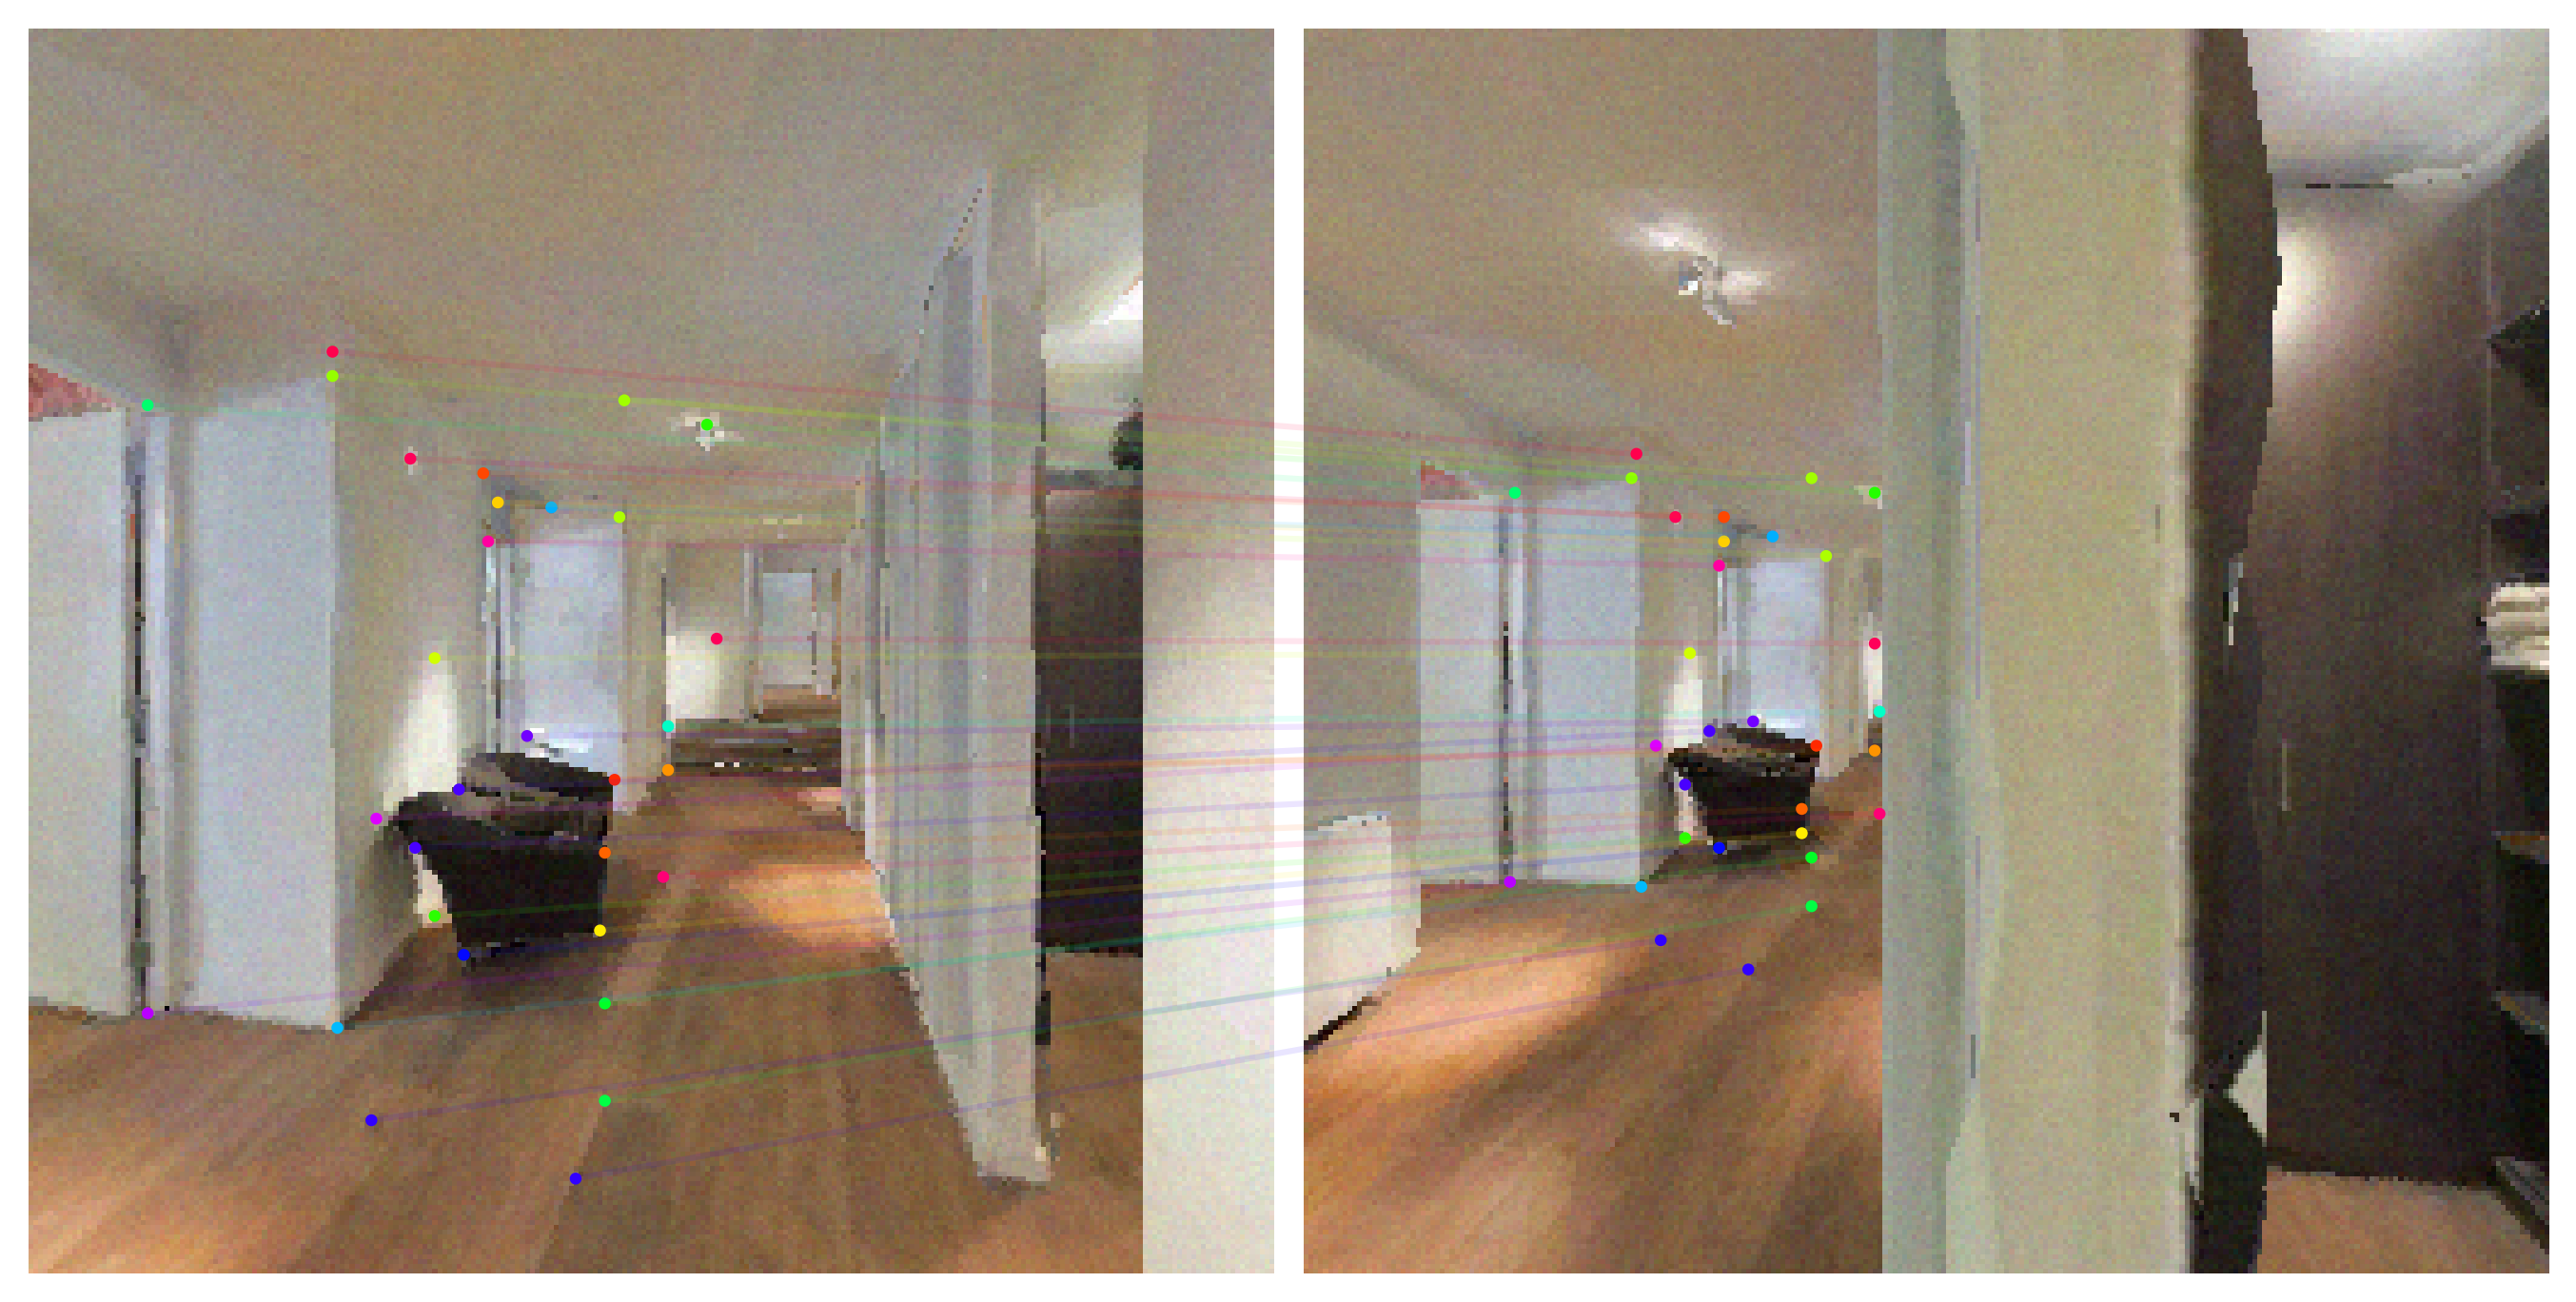

In [463]:
root_dir_images = images_path
first_image = Path(db_image)
second_image = Path(query_image)
keypoints_filename = Path(feature_filename)
visualization.visualize_matches(str(outputs / feature_filename), matches, root_dir_images, os.path.join(root_dir_images, query_image), os.path.join(root_dir_images, db_image), dpi=300)

In [188]:
len(keypoints_query)

127

In [189]:
for i, keypoint_xy_query in enumerate(keypoints_query):
    # Если кипоинт не имеет сопоставления, то пропускаем его
    if list(valid).count(i) == 0:
        continue
    depth_keypoint = depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
    point_3d_xyz_g2o = get_point_3d(keypoint_xy_query[0], keypoint_xy_query[1], depth_keypoint, fx, fy, cx, cy, result.matrix()[:3,3], result.matrix()[:3,:3])
    point_3d_xyz_query = get_point_3d(keypoint_xy_query[0], keypoint_xy_query[1], depth_keypoint, fx, fy, cx, cy, pose_query[:3,3], pose_query[:3,:3])
    if len(point_3d_xyz) != 1:
        if (math.isnan(depth_keypoint)) or (math.isinf(depth_keypoint)):
            continue
        else:
#             data['points_query'].append(point_3d_xyz_query.tolist())
            data['points_g2o'].append(point_3d_xyz_g2o.tolist())

UnboundLocalError: local variable 'matrix' referenced before assignment

In [190]:
with open('/home/g2o_data.json', 'w') as outfile:
    json.dump(data, outfile)

In [32]:
len(keypoints_db)

59

# Ransac

In [ ]:
pair = names_to_pair(query_image, db_image)
# if not(pair in match_file.keys()):
#     pair = names_to_pair(db_image, query_image)
# matches - список индексов ключевых точек на query изображении в порядке сопоставления с кипоинтами db
# matches = match_file[pair]['matches0'].__array__()
matches = np.arange(len(keypoints_db))
# valid - список индексов ключевых точек на query изображении, которые имеют сопоставление
valid = np.where(matches > -1)[0]
# matched_keypoints_query, matched_keypoints_db = keypoints_query[valid], keypoints_db[matches[valid]]
# num_matches = len(matched_keypoints_query)
points3D_ids = np.array(images['db']['points_3d'])
# matched_keypoints_query = keypoints_db
valid = valid[points3D_ids[matches[valid]] != -1]
kp_idx_to_3D = defaultdict(list)
kp_idx_to_3D_to_db = defaultdict(lambda: defaultdict(list))
i = 0
# Пробегаемся по индексам ключевых точек на изображении query, которые имеют сопоставление с db
# for idx in valid:
#     # берем индекс (idx) ключевой точки на изображении query;
#     # затем берем индекс кипоинта на изображении db, соответствующий этому кипоинту на query -  matches[idx]
#     # затем получаем индекс 3D ключевой точки по ключу индекса ключевой точки на db изображении
#     id_3D = points3D_ids[matches[idx]]
#     kp_idx_to_3D_to_db[idx][id_3D].append(i)
#     # avoid duplicate observations
#     if id_3D not in kp_idx_to_3D[idx]:
#         kp_idx_to_3D[idx].append(id_3D)
idxs = list(kp_idx_to_3D.keys())
mkp_idxs = [i for i in idxs for _ in kp_idx_to_3D[i]]
mkpq = keypoints_query[mkp_idxs]
# mkpq += 0.5  # COLMAP coordinates

mp3d_ids = [j for i in idxs for j in kp_idx_to_3D[i]]

mp3d = [list(points_3D[num_keypoint_in_db]['xyz']) for num_keypoint_in_db in valid if \
             images['db']['points_3d'][num_keypoint_in_db] != -1]
# mp3d = [points_3D[j]['xyz'] for j in mp3d_ids]
# mp3d = np.array(mp3d).reshape(-1, 3)

# mostly for logging and post-processing
# mkp_to_3D_to_db = [(j, kp_idx_to_3D_to_db[i][j])
#                    for i in idxs for j in kp_idx_to_3D[i]]

# camera_model, width, height, params = qinfo
cfg = {
       'model': 'PINHOLE',
       'width': int(width),
       'height': int(height),
       'params': np.array([fx, fy, cx, cy]),
}
# matched_keypoints_query += 0.5
keypoints_db += 0.5
ret = pycolmap.absolute_pose_estimation(keypoints_db, mp3d, cfg, 24)
print(ret['success'])
print(ret['tvec'])
print(yaw_pitch_roll_from_quaternion(list(ret['qvec']), w_first=True))

In [ ]:
ret['qvec']

In [ ]:
# All 6 images of base point. HFOV=90 degrees. TURN_ANGLE=60 degrees
num_db = 4
rgb_base = hdf5_file_db['rgb_base'][num_db]
rgb = hdf5_file_query['rgb'][num_query]
gps_base = hdf5_file_db['gps_base']
gps = hdf5_file_query['gps']
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(121)
ax1.set_title('query')
ax2 = f.add_subplot(122)
ax2.imshow(rgb_base)
ax1.imshow(rgb)
ax2.set_title('database')

db_quat_wxyz = hdf5_file_db['quat_base'][num_db]
r = R.from_quat([db_quat_wxyz[1], db_quat_wxyz[2], db_quat_wxyz[3], db_quat_wxyz[0]])
euler_x_db, euler_y_db, euler_z_db = r.as_euler('xyz', degrees=True)
print('database pose:')
print('    translation: {}'.format(gps_base[num_db]))
print('    yaw, pitch, roll: {:.2f}, {:.2f}, {:.2f}'.format(euler_x_db, euler_y_db, euler_z_db))

r = R.from_quat([ret['qvec'][1], ret['qvec'][2], ret['qvec'][3], ret['qvec'][0]])
euler_x_pred, euler_y_pred, euler_z_pred = r.as_euler('xyz', degrees=True)
print()
print('query pose calculated:')
print('    translation: {}'.format(ret['tvec']))
print('    yaw, pitch, roll: {:.2f}, {:.2f}, {:.2f}'.format(euler_x_pred, euler_y_pred, euler_z_pred))

gt_quat_wxyz = hdf5_file_query['quat'][num_query]
r = R.from_quat([gt_quat_wxyz[1], gt_quat_wxyz[2], gt_quat_wxyz[3], gt_quat_wxyz[0]])
euler_x_gt, euler_y_gt, euler_z_gt = r.as_euler('xyz', degrees=True)
print()
print('query pose gt:')
print('    translation: {}'.format(gps[num_query]))
print('    yaw, pitch, roll: {:.2f}, {:.2f}, {:.2f}'.format(euler_x_gt, euler_y_gt, euler_z_gt))

In [ ]:
root_dir_images = images_path
first_image = Path(db_image)
second_image = Path(query_image)
keypoints_filename = Path(feature_file)
visualization.visualize_matches(str(outputs / keypoints_filename), str(outputs / match_filename), root_dir_images, os.path.join(root_dir_images, second_image), os.path.join(root_dir_images, first_image), dpi=300)

# Visualization of keypoints

In [ ]:
keypoints_new = []
for i, keypoint in enumerate(keypoints_db):
    kp_idx_db = i
    # Получим индекс point 3D, соответствующий индексу ключевой точки kp_idx_db
    point_3D_id = images['db']['points_3d'][i]
    point = points_3D[point_3D_id]['xyz']
    x_right = keypoint[0] - fx_baseline/(depth_db[int(keypoint[1]), int(keypoint[0])][0])
    kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
    kp_left.pt  = (keypoint[0], keypoint[1])
    kp_right.pt = (x_right, keypoint[1])
    meas = Measurement(Measurement.Type.STEREO,
                       Measurement.Source.TRIANGULATION,
                       [kp_left, kp_right])
    mappoint = MapPoint(point)
    meas.mappoint = mappoint
    measurements.append(meas)

In [ ]:
cam_pose = result.matrix()
rotation_matrix = cam_pose[:3,:3]
rotation_matrix = quaternion_to_rotation_matrix(R_cam_db)
# cam_pose = np.eye(4)
# cam_pose[:3,:3] = rotation_matrix
# cam_pose[:3,3] = cam_xyz_db

In [ ]:
list_of_kps = []
for point_3D_id, point_3D in points_3D.items():
    if point_3D['image_ids'] == [2]:
        continue
    xyz = point_3D['xyz'] - cam_pose[:3, 3]
    xyz = np.matmul(np.linalg.inv(rotation_matrix), xyz)
    x = fx * xyz[0] / xyz[2] + cx
    y = fy * xyz[1] / xyz[2] + cy
    list_of_kps.append([int(x),int(y)])
array_of_kps = np.array([np.array(xi) for xi in list_of_kps])

In [ ]:
from hloc.utils.viz import plot_images, plot_keypoints, plot_matches, cm_RdGn

In [ ]:
def read_image(path):
    appendix = str(path).split('_')
    directory = str(path)[:str(path).rfind('/')]
    subdir = appendix[-4][appendix[-4].rfind('/'):]+'_'+appendix[-3]
    subdir = subdir[1:]
    filename = str(path).split('/')[-1] + '.png'
#     path = directory + '/' + subdir + '/' +  filename
    path = directory + '/' +  filename
    path = Path(path)
    assert path.exists(), path
    image = cv2.imread(str(path))
    if len(image.shape) == 3:
        image = image[:, :, ::-1]
    return image

In [ ]:
image = read_image(os.path.join(images_path, db_image))

In [ ]:
plot_images([image], dpi=300)
plot_keypoints([array_of_kps], colors='lime', ps=4)

In [ ]:
plot_images([image], dpi=300)
plot_keypoints([keypoints_db], colors='lime', ps=4)

In [ ]:
pwd

# Getting poses for query images

In [11]:
def quaternion_to_rotation_matrix(quaternion_wxyz):
    r = R.from_quat([quaternion_wxyz[1], quaternion_wxyz[2], quaternion_wxyz[3], quaternion_wxyz[0]])
    matrix = r.as_matrix()
    matrix[:3,2] = -matrix[:3,2]
    matrix[:3,1] = -matrix[:3,1]
    return matrix

In [12]:
def get_point_3d(x, y, depth, fx, fy, cx, cy, cam_center_world, R_world_to_cam, w_in_quat_first = True):
    if depth <= 0:
        return 0
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    if len(R_world_to_cam) == 4:
        if w_in_quat_first:
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
        else:
            R_world_to_cam = [R_world_to_cam[3], R_world_to_cam[0], R_world_to_cam[1], R_world_to_cam[2]]
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
    coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
    return coord_3D_cam_to_world

In [13]:
def yaw_pitch_roll_from_quaternion(quaternion, w_first=False):
    if not(w_first):
        r = R.from_quat(quaternion)
    else:
        r = R.from_quat([quaternion[1], quaternion[2], quaternion[3] ,quaternion[0]])
    return r.as_euler('yxz', degrees=True)

In [14]:
# loc_pairs = '/datasets/Habitat/NetVLAD.txt'
retrievals = parse_retrieval(loc_pairs)

In [28]:
path_to_hdf5_datasets = '/datasets/Habitat/HPointLoc'
keypoints_file = h5py.File(str(dataset / "ORB+DBOW2" / "keypoints.h5"), 'r')
# match_filename = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_HF-NET_top-3.h5'
match_file = h5py.File(str(dataset / "ORB+DBOW2" / "matches.h5"), 'r')

In [29]:
keypoints_file["ZMojNkEp431_point12_query_0003"]

<HDF5 group "/ZMojNkEp431_point12_query_0003" (1 members)>

In [30]:
fx, fy = 128., 128.
cx, cy = 128., 128.
width, height = 256, 256
fx_baseline = 300
baseline = fx_baseline/fx

cam = Camera(
    fx, fy, cx, cy, 
    width, height, 
    baseline)

top_num_db_image = 1
save_images = False

In [51]:
out = cv2.VideoWriter('/home/NetVLAD_wrong.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, (256, 256))

In [17]:
top_num_db_image = 1

In [46]:
output_folder_for_images = '/home/for_video'
os.makedirs(output_folder_for_images, exist_ok=True)
save_images = True

In [66]:
import PIL
from PIL import Image
from PIL import ImageFont, ImageDraw

In [206]:
fontsize = 13
font = ImageFont.truetype("DejaVuSans.ttf", fontsize)

In [18]:
# import faiss
# from sklearn.metrics.pairwise import cosine_similarity
import torch
from hloc.utils.base_model import dynamic_load
from hloc import matchers
confs = {
    'superglue': {
        'output': 'matches-superglue',
        'model': {
            'name': 'superglue',
            'weights': 'outdoor',
            'sinkhorn_iterations': 50,
        },
    },
    'NN': {
        'output': 'matches-NN-mutual-dist.7',
        'model': {
            'name': 'nearest_neighbor',
            'mutual_check': True,
            'distance_threshold': 0.7,
        },
    }
}

In [19]:
conf = confs['superglue']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Model = dynamic_load(matchers, conf['model']['name'])
model = Model(conf['model']).eval().to(device)

Loaded SuperGlue model ("outdoor" weights)


In [34]:
hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, map_name_query, hdf5_filename_query), 'r')

In [38]:
len(hdf5_file_query['rgb_base'])

6

In [32]:
# G2O

save_images = False

metrics = {
    "(5m, 20°)"   : 0, 
    "(1m, 10°)"   : 0,
    "(0,5m, 5°)"  : 0,
    "(0,25m, 2°)" : 0,
    "(5m)"        : 0,
    "(1m)"        : 0,
    "(0,5m)"      : 0,
    "(0,25m)"     : 0
}

optimizer = BundleAdjustment()
results = {}

max_angle_error = 0
count = 0
for query_image, values in tqdm(retrievals.items()):
#     if query_image != '1LXtFkjw3qL_point5_query_0000':
#         continue
    query_image = query_image.rstrip('.png')
#     print(query_image)
    measurements = []
    hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
    
    map_name_query = query_image.split('_')[0]
    if map_name_query == "1LXtFkjw3qL":
         map_name_query += "_point0"
    if map_name_query == "1pXnuDYAj8r":
        map_name_query += "_point0"
    if map_name_query == "5LpN3gDmAk7":
        map_name_query += "_point0"
    if map_name_query == "5q7pvUzZiYa":
        map_name_query += "_point1"
    
    hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, map_name_query, hdf5_filename_query), 'r')
    
    num_query = int(query_image.split('_')[-1])
    
    num_point_query = query_image.split('_')[1]
    
    is_base_query = ''
    if query_image.find('database') != -1:
        is_base_query = '_base'
    depth_query = 10*hdf5_file_query['depth'+is_base_query][num_query]
    
    # keypoints_query - массив из пар координта (x,y), которые являются кипоинтами на query image
    keypoints_query = keypoints_file[query_image]['keypoints'].__array__()
    
    # all_matched_keypoints_ids - массив из true/false, говорящий о том, имеет ли совпадение кипоинт с соответствующим индексом
    all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
    
    optimizer.clear()
    

    db_image = list(values[0].keys())[0]
    db_image = db_image.rstrip('.png')
#     print(db_image)
        
    map_name_database = db_image.split('_')[0]
    if map_name_database == "1LXtFkjw3qL":
        map_name_database += "_point0"
    if map_name_database == "1pXnuDYAj8r":
        map_name_database += "_point0"
    if map_name_database == "5LpN3gDmAk7":
        map_name_database += "_point0"
    if map_name_database == "5q7pvUzZiYa":
        map_name_database += "_point1"

    is_base_db = ''
    if db_image.find('database') != -1:
        is_base_db = '_base'

    score = list(values[0].values())[0]

    hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
    hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, map_name_database, hdf5_filename_db), 'r')

    num_db = int(db_image.split('_')[-1])

    num_point_db = db_image.split('_')[1]

    depth_db = 10*hdf5_file_db['depth'+is_base_db][num_db]

    translation = hdf5_file_db['gps'+is_base_db][num_db]
    orientation = quaternion_to_rotation_matrix(hdf5_file_db['quat'+is_base_db][num_db])
    pose_db = np.eye(4)
    pose_db[:3,:3] = orientation
    pose_db[:3,3] = translation

    pose_query = np.eye(4)
    pose_query[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'+is_base_query][num_query])
    pose_query[:3, 3] = hdf5_file_query['gps'+is_base_query][num_query]

#     diff_pose = np.linalg.inv(pose_db) @ pose_query
#     dist_diff = np.sum(diff_pose[:3, 3]**2) ** 0.5
#     r = R.from_matrix(diff_pose[:3, :3])
#     rotvec = r.as_rotvec()
#     angle_diff = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
#     angle_diff = abs(180 - abs(angle_diff-180))
    
#     if dist_diff <= 5 and angle_diff < 20:
#         metrics["(5m, 20°)"] += 1
#     if dist_diff <= 1 and angle_diff < 10:
#         metrics["(1m, 10°)"] += 1
#     if dist_diff <= 0.5 and angle_diff < 5:
#         metrics["(0,5m, 5°)"] += 1
#     if dist_diff <= 0.25 and angle_diff < 2:
#         metrics["(0,25m, 2°)"] += 1
#     if dist_diff <= 5:
#         metrics["(5m)"] += 1
#     if dist_diff <= 1:
#         metrics["(1m)"] += 1    
#     if dist_diff <= 0.5:
#         metrics["(0,5m)"] += 1
    
#     continue

#     if dist_diff < 1 or dist_diff > 2:
#         continue
#     if angle_diff < 5 or angle_diff > 10:
#         continue

    pose = g2o.Isometry3d(pose_db)
    optimizer.add_pose(0, pose, cam, fixed=False)

    
    keypoints_db = keypoints_file[db_image]['keypoints'].__array__()

    # Extract matches
#     data = {}
#     feats0, feats1 = keypoints_file[query_image], keypoints_file[db_image]
#     for k in feats1.keys():
#         data[k+'0'] = feats0[k].__array__()
#     for k in feats1.keys():
#         data[k+'1'] = feats1[k].__array__()
#     data = {k: torch.from_numpy(v)[None].float().to(device)
#             for k, v in data.items()}
#     data['image0'] = torch.empty((1, 1,)+tuple(feats0['image_size'])[::-1])
#     data['image1'] = torch.empty((1, 1,)+tuple(feats1['image_size'])[::-1])
#     pred = model(data)
#     matches_db_keypoints_ids = pred['matches0'][0].cpu().short().numpy()
    
    matches_db_keypoints_ids = match_file[query_image+"_"+db_image]['matches0'].__array__()

    # matched_keypoints_query_ids - массив из индексов кипоинтов на query image, которые имеют сопоставление
    matched_keypoints_query_ids = np.where(matches_db_keypoints_ids > -1)[0]

    # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
    for keypoint_id_query in matched_keypoints_query_ids:
        if all_matched_keypoints_ids[keypoint_id_query] == False:

            # затем получаем индекс сопоставленного кипоинта на database image
            keypoint_id_database = matches_db_keypoints_ids[keypoint_id_query]

            # получаем координаты x,y для сопоставленных кипоинтов на query и database
            keypoint_xy_query = keypoints_query[keypoint_id_query]
            keypoint_xy_db = keypoints_db[keypoint_id_database]

            # получаем глубины данных кипоинтов
            depth_keypoint_query = depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
            depth_keypoint_db = depth_db[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]

            # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
            if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
                continue

            # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
            x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query

            # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
            kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
            kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
            kp_right.pt = (x_right, keypoint_xy_query[1])
            meas = Measurement(Measurement.Type.STEREO,
                   Measurement.Source.TRIANGULATION,
                   [kp_left, kp_right])

            #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
            # с кипоинтом на query image
            # Получаем 3D координату ключевой точки на database image
            global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                                  fx, fy, cx, cy, \
                                                  translation, hdf5_file_db['quat'+is_base_db][num_db])
            mappoint = MapPoint(global_xyz_of_keypoint)
            # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
            # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
            meas.mappoint = mappoint
            measurements.append(meas)

            # Помечаем этот кипоинт на query image тем, что в дальнейшем его не нужно рассматривать - его уже
            # добавили в измерения
            all_matched_keypoints_ids[keypoint_id_query] = True
    for i, m in enumerate(measurements):
        optimizer.add_point(i, m.mappoint.position, fixed=True)
        optimizer.add_edge(0, i, 0, m)
    optimizer.optimize(10)
    result = optimizer.get_pose(0)
#     data['g2o']['cam_pose'] = result
    
    pose_estimated = np.eye(4)
    pose_query = np.eye(4)
    
#     r = R.from_quat([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
    
#     # Now get pose from g2o optimization 
    matrix = result.matrix()[:3,:3]
    pose_estimated[:3, :3] = matrix
    pose_estimated[:3, 3] = result.position()

    # Now get pose from Global Descriptor retrieval
#     pose_estimated[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
#     pose_estimated[:3, 3] = hdf5_file_db['gps_base'][num_db]
    
#     orientation_quat_xyzw = [hdf5_file_query['quat'][num_query][1], hdf5_file_query['quat'][num_query][2],\
#                             hdf5_file_query['quat'][num_query][3], hdf5_file_query['quat'][num_query][0]]
#     r = R.from_quat(orientation_quat_xyzw)
#     matrix = r.as_matrix()
    pose_query[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'+is_base_query][num_query])
    pose_query[:3, 3] = hdf5_file_query['gps'+is_base_query][num_query]
#     data['query']['cam_pose'] = pose_query 
#     print("GT translation:")
#     print(hdf5_file_query['gps'][num_query])
    error_pose = np.linalg.inv(pose_estimated) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(180 - abs(angle_error-180))
    
    if dist_error <= 5 and angle_error < 20:
        metrics["(5m, 20°)"] += 1
    if dist_error <= 1 and angle_error < 10:
        metrics["(1m, 10°)"] += 1
    if dist_error <= 0.5 and angle_error < 5:
        metrics["(0,5m, 5°)"] += 1
    if dist_error <= 0.25 and angle_error < 2:
        metrics["(0,25m, 2°)"] += 1
    if dist_error <= 5:
        metrics["(5m)"] += 1
    if dist_error <= 1:
        metrics["(1m)"] += 1    
    if dist_error <= 0.5:
        metrics["(0,5m)"] += 1
    
#     for key, value in metrics.items():
#         degree_thr = float(key.split(' ')[-2])
#         position_thr = float(key.split(' ')[0])
#         if angle_error < degree_thr and dist_error < position_thr:
#             metrics[key] += 1
    
    if dist_error < 0.25 and angle_error > 2 and save_images:
        new_image = Image.new('RGB',(2*256, 256), (250,250,250))

        db_image1 = list(retrievals[query_image+'.png'][0].keys())[0]
#         db_image2 = list(retrievals[query_image+'.png'][1].keys())[0]
#         db_image3 = list(retrievals[query_image+'.png'][2].keys())[0]
        
        image1 = Image.open(str(images_path / query_image)+'.png')
        image2 = Image.open(str(images_path / db_image1))
#         image3 = Image.open(str(images_path / db_image2))
#         image4 = Image.open(str(images_path / db_image3))
        
        metric1 = list(retrievals[query_image+'.png'][0].values())[0]
#         metric2 = list(retrievals[query_image+'.png'][1].values())[0]
#         metric3 = list(retrievals[query_image+'.png'][2].values())[0]
        
        new_image.paste(image1,(0,0))
        new_image.paste(image2,(255,0))
#         new_image.paste(image3,(2*255,0))
#         new_image.paste(image4,(3*255,0))

        draw = ImageDraw.Draw(new_image)
        
        draw.text((0, 0), query_image,(255,255,255), font=font)
        draw.text((image1.size[0], 0),"{}\n \
                                       score = {}\n \
                                       num matches = {}".format(db_image1.rstrip('.png'), 
                                                                round(float(metric1),3), 
                                                                len(matched_keypoints_query_ids)),
                  (255,255,255),font=font)
        
#         draw.text((2*image1.size[0], 0),"{}\nsim: {}".format(db_image2.rstrip('.png'), round(float(metric2),3)),(255,255,255),font=font)
#         draw.text((3*image1.size[0], 0),"{}\nsim: {}".format(db_image3.rstrip('.png'), round(float(metric3),3)),(255,255,255),font=font)

        new_image.save('{}/{:04}.jpg'.format(output_folder_for_images, count),'JPEG')
        count += 1
#     results[query_image] = {
#         'estimated_pose'   : pose_estimated.tolist(),
#         'gt_query_pose'    : pose_query.tolist(),
#         'gt_database_pose' : pose_db.tolist(),
#         'dist_error'       : float(dist_error),
#         'angle_error'      : float(angle_error),
#         'retrieved_image'  : db_image,
#         'num_matches'      : len(matched_keypoints_query_ids),
#         'retrival_conf'    : float(metric1)
#     }
    

# for key in metrics.keys():
#     metrics[key] = metrics[key] / 950

100%|██████████| 76136/76136 [1:35:47<00:00, 13.25it/s]  


In [33]:
for key in metrics.keys():
    metrics[key] = metrics[key] / len(retrievals.keys())
metrics

{'(5m, 20°)': 0.8756698539455711,
 '(1m, 10°)': 0.8572817064200904,
 '(0,5m, 5°)': 0.6477618997583272,
 '(0,25m, 2°)': 0.4043816328675003,
 '(5m)': 0.9008747504465693,
 '(1m)': 0.8704423662918988,
 '(0,5m)': 0.6608306188925082,
 '(0,25m)': 0.0}

In [29]:
with open('/datasets/Habitat/NetVLAD+SP+SG_localization_all_maps.json', 'w') as f:
    json.dump(results, f)

In [8]:
# # with open('/datasets/Habitat/HFNET+SP+SG_localization_all_maps.json', 'r') as f:
#     results = json.load(f)

In [14]:
out = cv2.VideoWriter('/home/NetVLAD_wrong.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, (256, 256))
output_folder_for_images = '/home/for_video'
os.makedirs(output_folder_for_images, exist_ok=True)
save_images = True

import PIL
from PIL import Image
from PIL import ImageFont, ImageDraw
from sklearn.metrics.pairwise import cosine_similarity


fontsize = 13
font = ImageFont.truetype("DejaVuSans.ttf", fontsize)

count = 0

In [35]:
# os.makedirs(output_folder_for_images, exist_ok=True)
save_image = False
metrics = {
    "(5m, 20°)"   : 0, 
    "(1m, 10°)"   : 0,
    "(0,5m, 5°)"  : 0,
    "(0,25m, 2°)" : 0,
    "(5m)"        : 0,
    "(1m)"        : 0,
    "(0,5m)"      : 0,
    "(0,25m)"     : 0
}
count = 0
for query_image in tqdm(results.keys()):
    
    db_image = results[query_image]['retrieved_image']
    
    map_name_database = db_image.split('_')[0]
    if map_name_database == "1LXtFkjw3qL":
        map_name_database += "_point0"
    if map_name_database == "1pXnuDYAj8r":
        map_name_database += "_point0"
    if map_name_database == "5LpN3gDmAk7":
        map_name_database += "_point0"
    if map_name_database == "5q7pvUzZiYa":
        map_name_database += "_point1"
            
    map_name_query = query_image.split('_')[0]
    if map_name_query == "1LXtFkjw3qL":
         map_name_query += "_point0"
    if map_name_query == "1pXnuDYAj8r":
        map_name_query += "_point0"
    if map_name_query == "5LpN3gDmAk7":
        map_name_query += "_point0"
    if map_name_query == "5q7pvUzZiYa":
        map_name_query += "_point1"
    
#     pose_estimated = np.array(results[query_image]['gt_database_pose'])
    db_pose = np.array(results[query_image]['gt_database_pose'])
    pose_estimated = np.array(results[query_image]['estimated_pose'])
    pose_query = np.array(results[query_image]['gt_query_pose'])
    
    error_pose_db = np.linalg.inv(db_pose) @ pose_query
    dist_error_db = np.sum(error_pose_db[:3, 3]**2) ** 0.5

    error_pose = np.linalg.inv(db_pose) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(180 - abs(angle_error-180))
    
    if dist_error <= 5 and angle_error < 20:
        metrics["(5m, 20°)"] += 1
    if dist_error <= 1 and angle_error < 10:
        metrics["(1m, 10°)"] += 1
    if dist_error <= 0.5 and angle_error < 5:
        metrics["(0,5m, 5°)"] += 1
    if dist_error <= 0.25 and angle_error < 2:
        metrics["(0,25m, 2°)"] += 1
    if dist_error <= 5:
        metrics["(5m)"] += 1
    if dist_error <= 1:
        metrics["(1m)"] += 1    
    if dist_error <= 0.5:
        metrics["(0,5m)"] += 1
    elif dist_error_db <= 0.5 and save_image:
        new_image = Image.new('RGB',(2*256, 256), (250,250,250))

        db_image1 = db_image
        
        image1 = Image.open(str(images_path / Path(map_name_query) / Path("images") / Path(query_image))+'.png')
        image2 = Image.open(str(images_path / Path(map_name_database) / Path("images") / Path(db_image1))+'.png')
        
        new_image.paste(image1,(0,0))
        new_image.paste(image2,(255,0))

        draw = ImageDraw.Draw(new_image)
        
        query_x, query_y, query_z = pose_query[:3,3]
        query_x, query_y, query_z = round(query_x,1), round(query_y,1), round(query_z,1)
        
        r = R.from_matrix(pose_query[:3,:3])
        query_yaw, query_roll, query_pitch = r.as_euler('yxz', degrees=True)
        query_yaw, query_roll, query_pitch = round(query_yaw,1), round(query_roll,1), round(query_pitch,1)
        
        es_x, es_y, es_z = pose_estimated[:3,3]
        es_x, es_y, es_z = round(es_x,1), round(es_y,1), round(es_z,1)
        
        r = R.from_matrix(pose_estimated[:3,:3])
        es_yaw, es_roll, es_pitch = r.as_euler('yxz', degrees=True)
        es_yaw, es_roll, es_pitch = round(es_yaw,1), round(es_roll,1), round(es_pitch,1)
        
        db_x, db_y, db_z = db_pose[:3,3]
        db_x, db_y, db_z = round(db_x,1), round(db_y,1), round(db_z,1)
        
        r = R.from_matrix(db_pose[:3,:3])
        db_yaw, db_roll, db_pitch = r.as_euler('yxz', degrees=True)
        db_yaw, db_roll, db_pitch = round(db_yaw,1), round(db_roll,1), round(db_pitch,1)
        
        draw.text((0, 0), "{}\n {} {} {} {} {} {}".format(query_image.rstrip('.png'), \
                                                             query_x, query_y, query_z, \
                                                             query_yaw, query_pitch, query_roll),\
                  (255,255,255), font=font)
        
        draw.text((image1.size[0], 0),"{}\ng2o: {} {} {} {} {} {}\ndb: {} {} {} {} {} {}".format(
                   db_image.rstrip('.png'), \
                   es_x, es_y, es_z, \
                   es_yaw, es_pitch, es_roll,\
                   db_x, db_y, db_z, \
                   db_yaw, db_pitch, db_roll),\
                   (255,255,255),font=font)

        new_image.save('{}/{:04}.jpg'.format(output_folder_for_images, count),'JPEG')
        count += 1
    if dist_error <= 0.25:
        metrics["(0,25m)"] += 1 

100%|██████████| 76136/76136 [00:15<00:00, 4930.60it/s]


In [32]:
imgage_array = []

for filename in tqdm(sorted(os.listdir(output_folder_for_images))):
    img = cv2.imread(os.path.join(output_folder_for_images, filename))
    height, width, layers = img.shape
    size = (width,height)
    imgage_array.append(img)

out = cv2.VideoWriter('/home/video_Habitat.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)

for i in tqdm(range(len(imgage_array))):
    cv2.waitKey(10000)
    out.write(imgage_array[i])
out.release()

100%|██████████| 3527/3527 [00:04<00:00, 809.34it/s]


In [36]:
for key in metrics.keys():
    metrics[key] = metrics[key] / len(results.keys())

In [38]:
metrics

{'(5m, 20°)': 0.6429021750551644,
 '(1m, 10°)': 0.31657822843332983,
 '(0,5m, 5°)': 0.15754702112010088,
 '(0,25m, 2°)': 0.03442523904591783,
 '(5m)': 0.9565251654933278,
 '(1m)': 0.8769701586634444,
 '(0,5m)': 0.8755910475990333,
 '(0,25m)': 0.48685247451928126}

In [ ]:
# G2O

max_num_top = 1

set_of_query_images = set()

data = {
    'query'    : {},
    'database' : {},
    'g2o'      : {}
}

optimizer = BundleAdjustment()
results = {}
metrics = {
    "(5m, 20°)"   : 0,
    "(1m, 10°)"   : 0,
    "(0.5m, 5°)"  : 0,
    "(0.25m, 2°)" : 0
}
max_angle_error = 0

with open(str(loc_pairs)) as f:
    lines = f.readlines()

for line in tqdm(lines):
#     if query_image != '1LXtFkjw3qL_point5_query_0000':
#         continue
    query_image, db_image, cos_score, l2_metric = line.split(' ')
    query_image = query_image.rstrip('.png')
    db_image = db_image.rstrip('.png')
    
    if not (query_image in set_of_query_images):
        top_num_db = 0
        set_of_query_images.add(query_image)
        measurements = []
        optimizer.clear()
        hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
        hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
    
        num_query = int(query_image.split('_')[-1])
        num_point_query = query_image.split('_')[1]
    
        depth_query = 10*hdf5_file_query['depth'][num_query]
    
        # keypoints_query - массив из пар координта (x,y), которые являются кипоинтами на query image
        keypoints_query = keypoints_file[query_image]['keypoints'].__array__()
    
        # all_matched_keypoints_ids - массив из true/false, говорящий о том, имеет ли совпадение кипоинт с соответствующим индексом
        all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
    
    top_num_db += 1
    
    if top_num_db  <= max_num_top:    
        num_point_db = db_image.split('_')[1]
        hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
        hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
        
        num_db = int(db_image.split('_')[-1])
        
        depth_db = 10*hdf5_file_db['depth_base'][num_db]
        
        translation = hdf5_file_db['gps_base'][num_db]
        orientation = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
        pose_44 = np.eye(4)
        pose_44[:3,:3] = orientation
        pose_44[:3,3] = translation
    
        # NetVLAD predictions
        if top_num_db == 1:
            pose_estimated[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
            pose_estimated[:3, 3] = hdf5_file_db['gps_base'][num_db]
    
        data['database']['cam_pose'] = pose_44
        pose = g2o.Isometry3d(pose_44)
        optimizer.add_pose(0, pose, cam, fixed=False)
        
        keypoints_db = keypoints_file[db_image]['keypoints'].__array__()
        
        # matches_db_keypoints_ids - массив из индексов кипоинтов на database image, которые совпадают с кипоинтом, индекс которого равен положению в массиве
        matches_db_keypoints_ids = match_file['_'.join([query_image,db_image])]['matches0'].__array__()
        
        # matched_keypoints_query_ids - массив из индексов кипоинтов на query image, которые имеют сопоставление
        matched_keypoints_query_ids = np.where(matches_db_keypoints_ids > -1)[0]
        
        # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
        for keypoint_id_query in matched_keypoints_query_ids:
            if all_matched_keypoints_ids[keypoint_id_query] == False:
                
                # затем получаем индекс сопоставленного кипоинта на database image
                keypoint_id_database = matches_db_keypoints_ids[keypoint_id_query]
                
                # получаем координаты x,y для сопоставленных кипоинтов на query и database
                keypoint_xy_query = keypoints_query[keypoint_id_query]
                keypoint_xy_db = keypoints_db[keypoint_id_database]
                
                # получаем глубины данных кипоинтов
                depth_keypoint_query = depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
                depth_keypoint_db = depth_db[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]
                
                # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
                if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
                    continue
                    
                # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
                x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query
                
                # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
                kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
                kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
                kp_right.pt = (x_right, keypoint_xy_query[1])
                meas = Measurement(Measurement.Type.STEREO,
                                   Measurement.Source.TRIANGULATION,
                                   [kp_left, kp_right])
                
                #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
                # с кипоинтом на query image
                # Получаем 3D координату ключевой точки на database image
                global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                                      fx, fy, cx, cy, \
                                                      translation, hdf5_file_db['quat_base'][num_db])
                mappoint = MapPoint(global_xyz_of_keypoint)
                # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
                # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
                meas.mappoint = mappoint
                measurements.append(meas)
                
                # Помечаем этот кипоинт на query image тем, что в дальнейшем его не нужно рассматривать - его уже
                # добавили в измерения
                all_matched_keypoints_ids[keypoint_id_query] = True
    else:
        for i, m in enumerate(measurements):
            optimizer.add_point(i, m.mappoint.position, fixed=True)
            optimizer.add_edge(0, i, 0, m)
        optimizer.optimize(10)
        result = optimizer.get_pose(0)
        data['g2o']['cam_pose'] = result
    
        pose_estimated = np.eye(4)
        pose_query = np.eye(4)
    
#     r = R.from_quat([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
    
#     # Now get pose from g2o optimization 
#     matrix = result.matrix()[:3,:3]
#     pose_estimated[:3, :3] = matrix
#     pose_estimated[:3, 3] = result.position()
#     print("Estimated translation:")
#     print(result.position())
#     print(matrix)

    # Now get pose from NetVLAD
#     pose_estimated[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
#     pose_estimated[:3, 3] = hdf5_file_db['gps_base'][num_db]
    
#     orientation_quat_xyzw = [hdf5_file_query['quat'][num_query][1], hdf5_file_query['quat'][num_query][2],\
#                             hdf5_file_query['quat'][num_query][3], hdf5_file_query['quat'][num_query][0]]
#     r = R.from_quat(orientation_quat_xyzw)
#     matrix = r.as_matrix()
        pose_query[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'][num_query])
        pose_query[:3, 3] = hdf5_file_query['gps'][num_query]
        data['query']['cam_pose'] = pose_query 
#     print("GT translation:")
#     print(hdf5_file_query['gps'][num_query])
        error_pose = np.linalg.inv(pose_estimated) @ pose_query
        dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
        r = R.from_matrix(error_pose[:3, :3])
        rotvec = r.as_rotvec()
        angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
        angle_error = abs(90 - abs(angle_error-90))
    
#     if num_point_db != num_point_query:
        
    
#     if angle_error > max_angle_error:
#         max_angle_error = angle_error
#         print(query_image)
#         print(db_image)
#         print(max_angle_error)
#         print("len of measurements = {}".format(len(measurements)))
#         print()
#         print()
#     print("angle error = {.f}", angle_error)
#     print("dist error = {.f}", dist_error)
#         print(db_image)
#         print(query_image)
#         print()

#     results[query_image] = {
#         'xyz': list(map(float, result.position())),
#         'quaternion_xyzw': list(map(float,r.as_quat()))
#     }
#     if angle_error < 20 and dist_error < 5:
#         metrics["(5m, 20°)"] += 1
#     if angle_error < 10 and dist_error < 1:
#         metrics["(1m, 10°)"] += 1
#     if angle_error < 5 and dist_error < 0.5:
#         metrics["(0.5m, 5°)"] += 1
#     if angle_error < 2 and dist_error < 0.25:
#         metrics["(0.25m, 2°)"] += 1
        if dist_error < 5:
            metrics["(5m, 20°)"] += 1
        if dist_error < 1:
            metrics["(1m, 10°)"] += 1
        if dist_error < 0.5:
            metrics["(0.5m, 5°)"] += 1
        if dist_error < 0.25:
            metrics["(0.25m, 2°)"] += 1
#     break
for key in metrics.keys():
    metrics[key] = metrics[key] / 950
# out.release()

In [ ]:
out = cv2.VideoWriter('/home/NetVLAD_wrong.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, (256, 256))

In [85]:
metrics

{'(5m, 20°)': 0.8547368421052631,
 '(1m, 10°)': 0.035789473684210524,
 '(0.5m, 5°)': 0.0,
 '(0.25m, 2°)': 0.0}

## Getting table of localizations

In [52]:
def quaternion_to_rotation_matrix(quaternion_wxyz):
    r = R.from_quat([quaternion_wxyz[1], quaternion_wxyz[2], quaternion_wxyz[3], quaternion_wxyz[0]])
    matrix = r.as_matrix()
    matrix[:3,2] = -matrix[:3,2]
    matrix[:3,1] = -matrix[:3,1]
    return matrix

In [53]:
def get_point_3d(x, y, depth, fx, fy, cx, cy, cam_center_world, R_world_to_cam, w_in_quat_first = True):
    if depth <= 0:
        return 0
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    if len(R_world_to_cam) == 4:
        if w_in_quat_first:
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
        else:
            R_world_to_cam = [R_world_to_cam[3], R_world_to_cam[0], R_world_to_cam[1], R_world_to_cam[2]]
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
    coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
    return coord_3D_cam_to_world

In [54]:
retrievals = parse_retrieval(loc_pairs)

In [61]:
path_to_images = str(images_path)
path_to_hdf5_datasets = '/datasets/Habitat/HPointLoc/1LXtFkjw3qL_point0'

In [62]:
distances = np.array([0, 0.25, 0.5, 1, 2, 3, 4, 5, 10, 20, 30, 50])
angles = np.array([0, 1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 120, 150, 180], dtype=float)

table = {}
for distance in distances:
    if distance == 0:
        continue
    for angle in angles:
        if angle == 0:
            continue
        table[str(distance)+" m and "+ str(angle) + " deg"] = {
            'tp'           : 0,
            'all'           : 0,
            'queries-dbs' : {}
        }

In [63]:
keypoints_file = h5py.File(str(outputs / feature_filename), 'r')
match_filename = 'feats-superpoint-n4096-r1024-nms4_matches-superglue_HF_Net_qdb_qdb.h5'
match_file = h5py.File(str(outputs / match_filename), 'r')

In [68]:
images_path = dataset / 'extracted_HPointLoc/1LXtFkjw3qL_point0/images'
path_to_images = str(images_path)

In [72]:
# optimizer = BundleAdjustment()

for filename1 in tqdm(sorted(os.listdir(path_to_images))):
    query1_filename = filename1.rstrip('.png')
    hdf5_filename_query1 = '_'.join(query1_filename.split('_')[:2]) + '.hdf5'
    hdf5_file_query1 = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query1), 'r')
    num_query1 = int(query1_filename.split('_')[-1])
    
    is_database = ''
    if query1_filename.find('database') != -1:
        is_database = '_base'
    
    depth_query1 = 10*hdf5_file_query1['depth'+is_database][num_query1]
    
    translation = hdf5_file_query1['gps'+is_database][num_query1]
    orientation = quaternion_to_rotation_matrix(hdf5_file_query1['quat'+is_database][num_query1])
    pose_44_query1 = np.eye(4)
    pose_44_query1[:3,:3] = orientation
    pose_44_query1[:3,3] = translation
    
    # Заполняем таблицу метрик    
    for filename2 in sorted(os.listdir(path_to_images)):
        if filename1 == filename2:
            continue
        query2_filename = filename2.rstrip('.png')
        hdf5_filename_query2 = '_'.join(query2_filename.split('_')[:2]) + '.hdf5'
        hdf5_file_query2 = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query2), 'r')
        
        num_query2 = int(query2_filename.split('_')[-1])
        
        is_database = ''
        if query2_filename.find('database') != -1:
            is_database = '_base'
        
        translation = hdf5_file_query2['gps'+is_database][num_query2]
        orientation = quaternion_to_rotation_matrix(hdf5_file_query2['quat'+is_database][num_query2])
        pose_44_query2 = np.eye(4)
        pose_44_query2[:3,:3] = orientation
        pose_44_query2[:3,3] = translation
        
        diff_pose = np.linalg.inv(pose_44_query2) @ pose_44_query1
        dist_diff = np.sum(diff_pose[:3, 3]**2) ** 0.5
        r = R.from_matrix(diff_pose[:3, :3])
        rotvec = r.as_rotvec()
        angle_diff = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
        angle_diff = abs(180 - abs(angle_diff-180))
        
        num_dist =  [i for i in range(1, len(distances)-1) \
                     if (distances[i-1] < dist_diff) and (distances[i] >= dist_diff)]
        
        num_angle = [i for i in range(1, len(angles)-1) \
                     if (angles[i-1] < angle_diff) and (angles[i] >= angle_diff)]
        
        # Если не входит в таблицу, то пропускаем эту пару
        if len(num_dist) == 0 or len(num_angle) == 0:
            continue
        
        if query1_filename in table[str(distances[num_dist[0]])+" m and " + str(angles[num_angle[0]])+" deg"]['queries-dbs'].keys():
            table[str(distances[num_dist[0]])+" m and " + str(angles[num_angle[0]])+" deg"]['queries-dbs'][query1_filename]["db_filenames"].append(query2_filename)
#             table[str(distances[num_dist[0]])+" m and " + str(angles[num_angle[0]])+" deg"]["all"] += 1
        else:
            table[str(distances[num_dist[0]])+" m and " + str(angles[num_angle[0]])+" deg"]['queries-dbs'][query1_filename] = {
                "db_filenames"   : [query2_filename]
            }
#             table[str(distances[num_dist[0]])+" m and " + str(angles[num_angle[0]])+" deg"]["all"] += 1

100%|██████████| 1088/1088 [18:28<00:00,  1.02s/it]


In [49]:
# import faiss
# from sklearn.metrics.pairwise import cosine_similarity
import torch
from hloc.utils.base_model import dynamic_load
from hloc import matchers
confs = {
    'superglue': {
        'output': 'matches-superglue',
        'model': {
            'name': 'superglue',
            'weights': 'outdoor',
            'sinkhorn_iterations': 50,
        },
    },
    'NN': {
        'output': 'matches-NN-mutual-dist.7',
        'model': {
            'name': 'nearest_neighbor',
            'mutual_check': True,
            'distance_threshold': 0.7,
        },
    }
}

In [165]:
out = cv2.VideoWriter('/home/NetVLAD_wrong.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, (256, 256))
output_folder_for_images = '/home/for_video'
os.makedirs(output_folder_for_images, exist_ok=True)
save_images = True

import PIL
from PIL import Image
from PIL import ImageFont, ImageDraw
from sklearn.metrics.pairwise import cosine_similarity


fontsize = 13
font = ImageFont.truetype("DejaVuSans.ttf", fontsize)

count = 0

In [478]:
images_path = '/datasets/Habitat/1LXtFkjw3qL_point0/images/'

In [479]:
save_images = False

In [485]:
num_keypoints = 4096
path_to_global_descriptors = '/datasets/Habitat/HF_Net_output/global_descriptors'

conf = confs['superglue']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Model = dynamic_load(matchers, conf['model']['name'])
model = Model(conf['model']).eval().to(device)

count = 0

for cell in tqdm(table.keys()):
    if len(table[cell]['queries-dbs'].keys()) == 0:
        continue
        
#     if cell != "2.0 m and 10.0 deg":
#         continue
        
    for query_image in table[cell]['queries-dbs'].keys():
        
        # RUN global descriptor retrieval and find top-1 retrieval image
    
        dbFeat = []

        with open(os.path.join(path_to_global_descriptors, query_image+'.npy'), 'rb') as f:
            descriptor_query = np.load(f)
        qFeat = np.empty((1, num_keypoints))
        qFeat[0,:] = descriptor_query
        qFeat = qFeat.astype('float32')
        faiss_index = faiss.IndexFlatL2(num_keypoints)
        faiss_index.add(qFeat)
    
        measurements = []
        optimizer.clear()
        for db_image in table[cell]['queries-dbs'][query_image]["db_filenames"]:
        
            with open(os.path.join(path_to_global_descriptors, db_image+'.npy'), 'rb') as f:
                descriptor2 = np.load(f)
            dbFeat.append(descriptor2)
        
        dbFeat_temp = np.empty((len(dbFeat), num_keypoints))

        for i in range(len(dbFeat)):
            dbFeat_temp[i,:] = dbFeat[i]
    
        dbFeat = dbFeat_temp
    
        dbFeat = dbFeat.astype('float32')
        distances, predictions = faiss_index.search(dbFeat, 1)
        num_db = predictions[0][0]
        db_image = table[cell]['queries-dbs'][query_image]["db_filenames"][num_db]
        image_1 = query_image
        image_2 = db_image
        
        dbfeature = dbFeat[num_db]
        qfeature  = qFeat[0]
        dbfeature = np.reshape(dbfeature, (1,-1))
        qfeature = np.reshape(qfeature, (1,-1))
        simil_score = cosine_similarity(dbfeature, qfeature)[0][0]
    
        # Run SuperPoint + SuperGlue + G2O
    
        query1_filename = image_1
        is_database = ''
        if query1_filename.find('database') != -1:
            is_database = '_base'
        hdf5_filename_query1 = '_'.join(query1_filename.split('_')[:2]) + '.hdf5'
        hdf5_file_query1 = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query1), 'r')
        num_query1 = int(query1_filename.split('_')[-1])
        depth_query1 = 10*hdf5_file_query1['depth'+is_database][num_query1]
        translation = hdf5_file_query1['gps'+is_database][num_query1]
        orientation = quaternion_to_rotation_matrix(hdf5_file_query1['quat'+is_database][num_query1])
        pose_44_query1 = np.eye(4)
        pose_44_query1[:3,:3] = orientation
        pose_44_query1[:3,3] = translation
        keypoints_query = keypoints_file[query1_filename]['keypoints'].__array__()
    
        db_filename = image_2
        hdf5_filename_db = '_'.join(db_filename.split('_')[:2]) + '.hdf5'
        hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
        num_db = int(db_filename.split('_')[-1])
        is_database = ''
        if db_filename.find('database') != -1:
            is_database = '_base'
        translation = hdf5_file_db['gps'+is_database][num_db]
        orientation = quaternion_to_rotation_matrix(hdf5_file_db['quat'+is_database][num_db])
        pose_44_db = np.eye(4)
        pose_44_db[:3,:3] = orientation
        pose_44_db[:3,3] = translation
        depth_db = 10*hdf5_file_db['depth'+is_database][num_db]
        keypoints_db = keypoints_file[db_filename]['keypoints'].__array__()
    
        pose = g2o.Isometry3d(pose_44_db)
        optimizer.add_pose(0, pose, cam, fixed=False)
    
        retrieved_image = image_2
        hdf5_file_retrieved = hdf5_file_db
        num_retrieved = num_db
        depth_retrieved = depth_db
        
        # Extract matches
        
        data = {}
        feats0, feats1 = keypoints_file[query_image], keypoints_file[db_image]
        for k in feats1.keys():
            data[k+'0'] = feats0[k].__array__()
        for k in feats1.keys():
            data[k+'1'] = feats1[k].__array__()
        data = {k: torch.from_numpy(v)[None].float().to(device)
                for k, v in data.items()}
        data['image0'] = torch.empty((1, 1,)+tuple(feats0['image_size'])[::-1])
        data['image1'] = torch.empty((1, 1,)+tuple(feats1['image_size'])[::-1])
        
        pred = model(data)
        
        matches_db_keypoints_ids = pred['matches0'][0].cpu().short().numpy()
        matched_keypoints_query_ids = np.where(matches_db_keypoints_ids > -1)[0]
        
        # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
        for num_kp, keypoint_id in enumerate(matched_keypoints_query_ids):
            if keypoint_id == -1:
                continue
            # затем получаем индекс сопоставленного кипоинта на database image
            keypoint_id_query = keypoint_id
            keypoint_id_database = matches_db_keypoints_ids[keypoint_id]
                
            # получаем координаты x,y для сопоставленных кипоинтов на query и database
            keypoint_xy_query = keypoints_query[keypoint_id_query]
            keypoint_xy_db = keypoints_db[keypoint_id_database]
                
            # получаем глубины данных кипоинтов
            depth_keypoint_query = depth_query1[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
            depth_keypoint_db = depth_retrieved[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]
                
            # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
            if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
                continue
                    
            # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
            x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query
                
            # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
            kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
            kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
            kp_right.pt = (x_right, keypoint_xy_query[1])
            meas = Measurement(Measurement.Type.STEREO,
                               Measurement.Source.TRIANGULATION,
                               [kp_left, kp_right])
                
            #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
            # с кипоинтом на query image
            # Получаем 3D координату ключевой точки на database image
            global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                     fx, fy, cx, cy, \
                                     translation, hdf5_file_retrieved['quat'+is_database][num_retrieved])
            mappoint = MapPoint(global_xyz_of_keypoint)
            # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
            # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
            meas.mappoint = mappoint
            measurements.append(meas)
                
        for i, m in enumerate(measurements):
            optimizer.add_point(i, m.mappoint.position, fixed=True)
            optimizer.add_edge(0, i, 0, m)
        optimizer.optimize(10)
        result = optimizer.get_pose(0)
    
        pose_estimated = np.eye(4)
        # Now get pose from g2o optimization 
        matrix = result.matrix()[:3,:3]
        pose_estimated[:3, :3] = matrix
        pose_estimated[:3, 3] = result.position()
    
        error_pose = np.linalg.inv(pose_estimated) @ pose_44_query1
        dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
        r = R.from_matrix(error_pose[:3, :3])
        rotvec = r.as_rotvec()
        angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
        angle_error = abs(180 - abs(angle_error - 180))
    
        table[cell]['all'] += 1
        if angle_error < 5 and dist_error < 0.5:
            table[cell]['tp'] += 1
            
        table[cell]['queries-dbs'][query_image]["estimated_pose"] = pose_estimated.tolist()
        table[cell]['queries-dbs'][query_image]["retrieved_image"] = retrieved_image
        table[cell]['queries-dbs'][query_image]["retrival_score"] = simil_score
        table[cell]['queries-dbs'][query_image]["num_matches"] = float(simil_score)
            
        if dist_error > 0.5 or angle_error > 5 and save_images:
            
            new_image = Image.new('RGB',(2*256, 256), (250,250,250))

            db_image1 = db_image
        
            image1 = Image.open(str(images_path / Path(query_image))+'.png')
            image2 = Image.open(str(images_path / Path(db_image1))+'.png')
        
#             metric1 = list(retrievals[query_image+'.png'][0].values())[0]
        
            new_image.paste(image1,(0,0))
            new_image.paste(image2,(255,0))

            draw = ImageDraw.Draw(new_image)
        
            draw.text((0, 0), query_image,(255,255,255), font=font)
            draw.text((image1.size[0], 0),"{}\n{}".format(db_image.rstrip('.png'), round(float(simil_score),3)),(255,255,255),font=font)

            new_image.save('{}/{:04}.jpg'.format(output_folder_for_images, count),'JPEG')
            count += 1
            
#         print(table[cell])
#         print(dist_error)
#         print(angle_error)
#     break

  0%|          | 0/176 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 176/176 [3:39:27<00:00, 74.82s/it]   


In [482]:
# imgage_array = []

# for filename in sorted(os.listdir(output_folder_for_images)):
#     img = cv2.imread(os.path.join(output_folder_for_images, filename))
#     height, width, layers = img.shape
#     size = (width,height)
#     imgage_array.append(img)

# out = cv2.VideoWriter('/home/video_Habitat.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)

# for i in range(len(imgage_array)):
#     cv2.waitKey(10000)
#     out.write(imgage_array[i])
# out.release()

In [492]:
import json
with open('table.json', 'w') as outfile:
    json.dump(table, outfile)

In [442]:
path_to_global_descriptors = '/datasets/Habitat/HF_Net_output/global_descriptors'

# image_filename1 = '1LXtFkjw3qL_point13_query_0002'
# image_filename2 = '1LXtFkjw3qL_point0_query_0029'

image_filename1 = '1LXtFkjw3qL_point12_query_0007'
image_filename2 = '1LXtFkjw3qL_point16_query_0038'

with open(os.path.join(path_to_global_descriptors, image_filename1+'.npy'), 'rb') as f:
    descriptor1 = np.load(f)
    
with open(os.path.join(path_to_global_descriptors, image_filename2+'.npy'), 'rb') as f:
    descriptor2 = np.load(f)

descriptor1 = np.reshape(descriptor1, (1,-1))
descriptor2 = np.reshape(descriptor2, (1,-1))
print(cosine_similarity(descriptor1, descriptor2)[0][0])
print(np.sqrt(np.sum((descriptor1-descriptor2)**2, axis=1)))

0.6093401
[0.88392293]


In [443]:
a = []
a.append([1,2,3])
np.asarray(a, dtype=float)

array([[1., 2., 3.]])

In [444]:
len(table[cell]['pair'])

KeyError: 'pair'

In [221]:
len(query_images_set)

129

In [222]:
len(db_images_set)

108

In [ ]:
    # Получаем предсказание image retrival
    retrieved_image = [key for key, value in retrievals[query1_filename+'.png'][0].items()][0]
    if retrieved_image == query1_filename+'.png':
        retrieved_image = [key for key, value in retrievals[query1_filename+'.png'][1].items()][0]
        
    # Выполняем подготовку для потимизации позы
    measurements = []
    optimizer.clear()
        
    hdf5_filename_retrieved = '_'.join(retrieved_image.split('_')[:2]) + '.hdf5'
    hdf5_file_retrieved = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_retrieved), 'r')
        
    num_retrieved = int(retrieved_image.rstrip('.png').split('_')[-1])
        
    is_database = ''
    if retrieved_image.find('database') != -1:
        is_database = '_base'
        
    depth_retrieved = 10*hdf5_file_retrieved['depth'+is_database][num_retrieved]
        
    translation = hdf5_file_retrieved['gps'+is_database][num_retrieved]
    orientation = quaternion_to_rotation_matrix(hdf5_file_retrieved['quat'+is_database][num_retrieved])
    pose_retrieved = np.eye(4)
    pose_retrieved[:3,:3] = orientation
    pose_retrieved[:3,3] = translation
    pose = g2o.Isometry3d(pose_retrieved)
    optimizer.add_pose(0, pose, cam, fixed=False)
        
    keypoints_db = keypoints_file[retrieved_image.rstrip('.png')]['keypoints'].__array__()
    keypoints_query = keypoints_file[query1_filename.rstrip('.png')]['keypoints'].__array__()
#     print(len(keypoints_query))
#     print(len(keypoints_db))
        
        # matches_db_keypoints_ids - массив из индексов кипоинтов на database image, которые совпадают с кипоинтом, индекс которого равен положению в массиве        
        # matched_keypoints_query_ids - массив из индексов кипоинтов на query image, которые имеют сопоставление
    inverse = False
    if '_'.join([query1_filename,retrieved_image.rstrip('.png')]) in match_file.keys():
        matches_db_keypoints_ids = match_file['_'.join([query1_filename, retrieved_image.rstrip('.png')])]['matches0'].__array__()
        matched_keypoints_query_ids = np.where(matches_db_keypoints_ids > -1)[0]
    elif '_'.join([retrieved_image.rstrip('.png'),query1_filename]) in match_file.keys():
        matched_keypoints_query_ids = match_file['_'.join([retrieved_image.rstrip('.png'), query1_filename])]['matches0'].__array__()
        matches_db_keypoints_ids = np.where(matched_keypoints_query_ids > -1)[0]
        inverse = True
    else:
        print('pair does not exist')
        print('_'.join([query1_filename,retrieved_image.rstrip('.png')]))
        
    # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
    for num_kp, keypoint_id in enumerate(matched_keypoints_query_ids):
        if keypoint_id == -1:
            continue
#         print(inverse)
#         print(matched_keypoints_query_ids)
#         print(matches_db_keypoints_ids)
#         print()
        # затем получаем индекс сопоставленного кипоинта на database image
        if not(inverse):
            keypoint_id_query = keypoint_id
            keypoint_id_database = matches_db_keypoints_ids[keypoint_id]
        else:
            keypoint_id_database = num_kp
            keypoint_id_query = keypoint_id
                
        # получаем координаты x,y для сопоставленных кипоинтов на query и database
        keypoint_xy_query = keypoints_query[keypoint_id_query]
        keypoint_xy_db = keypoints_db[keypoint_id_database]
                
        # получаем глубины данных кипоинтов
        depth_keypoint_query = depth_query1[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
        depth_keypoint_db = depth_retrieved[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]
                
        # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
        if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
            continue
                    
        # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
        x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query
                
        # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
        kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
        kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
        kp_right.pt = (x_right, keypoint_xy_query[1])
        meas = Measurement(Measurement.Type.STEREO,
                          Measurement.Source.TRIANGULATION,
                          [kp_left, kp_right])
                
        #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
        # с кипоинтом на query image
        # Получаем 3D координату ключевой точки на database image
        global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                            fx, fy, cx, cy, \
                                            translation, hdf5_file_retrieved['quat'+is_database][num_retrieved])
        mappoint = MapPoint(global_xyz_of_keypoint)
        # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
        # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
        meas.mappoint = mappoint
        measurements.append(meas)
                
    for i, m in enumerate(measurements):
        optimizer.add_point(i, m.mappoint.position, fixed=True)
        optimizer.add_edge(0, i, 0, m)
    optimizer.optimize(10)
    result = optimizer.get_pose(0)
    
    pose_estimated = np.eye(4)
    pose_query = np.eye(4)
    
    # Now get pose from g2o optimization 
    matrix = result.matrix()[:3,:3]
    pose_estimated[:3, :3] = matrix
    pose_estimated[:3, 3] = result.position()
    
    error_pose = np.linalg.inv(pose_estimated) @ pose_44_query1
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(90 - abs(angle_error-90))

In [68]:
# RANSAC

results = {}
metrics = {
    "(5m, 20°)": 0,
    "(1m, 10°)": 0,
    "(0.5m, 5°)": 0,
    "(0.25m, 2°)": 0
}
for query_image, db_images in tqdm(retrievals.items()):
    keypoints_2D = []
    keypoints_3D = []
    hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
    hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
    
    num_query = int(query_image.split('_')[-1])
    
    keypoints_query = keypoints_file[query_image]['keypoints'].__array__()
    all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
    
    for num in range(len(db_images)):
        if num >= top_num_db_image:
            break
        db_image = db_images[num]
        hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
        hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
        
        num_db = int(db_image.split('_')[-1])
        
        depth_db = 10*hdf5_file_db['depth_base'][num_db]
        
        translation = hdf5_file_db['gps_base'][num_db]
        orientation_matrix_44 = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
        pose_44 = np.eye(4)
        pose_44[:3,:3] = orientation_matrix_44
        pose_44[:3,3] = translation
        
        matches_db_keypoints_ids = match_file['_'.join([query_image,db_image])]['matches0'].__array__()
        matched_keypoints_query_ids = np.where(matches_db_keypoints_ids > -1)[0]
        for keypoint_id_query in matched_keypoints_query_ids:
            if all_matched_keypoints_ids[keypoint_id_query] == False:
                keypoint = keypoints_query[keypoint_id_query]
                depth_keypoint = depth_db[int(keypoint[1]), int(keypoint[0])][0]
                if depth_keypoint <= 0:
                    continue
                global_xyz_of_keypoint = get_point_3d(keypoint[0], keypoint[1], depth_keypoint, \
                                                      fx, fy, cx, cy, \
                                                      translation, hdf5_file_db['quat_base'][num_db])
                keypoint += 0.5
                keypoints_2D.append(list(keypoint))
                keypoints_3D.append(list(global_xyz_of_keypoint))
                all_matched_keypoints_ids[keypoint_id_query] = True           
#     ret = pycolmap.absolute_pose_estimation(keypoints_2D, keypoints_3D, cfg, 12)
#     print(ret['success'])
#     print(ret['tvec'])
#     print(yaw_pitch_roll_from_quaternion(list(ret['qvec']), w_first=True))
#     break
#     r = R.from_matrix(result.matrix()[:3,:3])
#     yaw_pitch_roll = r.as_euler('yxz', degrees=True)
    orientation_quat_wxyz = hdf5_file_db['quat_base'][num_db]
#     results[query_image] = {
#         'xyz': list(map(float,translation)),
#         'quaternion_xyzw': list([float(orientation[1]), float(orientation[2]), float(orientation[3]), float(orientation[0])])
#     }
#     r = R.from_quat(list([orientation[1], orientation[2], orientation[3], orientation[0]]))
#     yaw_pitch_roll = r.as_euler('yxz', degrees=True)
#     print(query_image)
#     print("NetVLAD")
#     print([orientation[1], orientation[2], orientation[3], orientation[0]])
#     print(translation)
#     print(yaw_pitch_roll)
#     print("query")

    pose_estimated = np.eye(4)
    pose_query = np.eye(4)
    
    r = R.from_quat([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
#     print([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
    pose_estimated[:3, :3] = r.as_matrix()
    pose_estimated[:3, 3] = translation
    
    orientation_quat_xyzw = [hdf5_file_query['quat'][num_query][1], hdf5_file_query['quat'][num_query][2],\
                            hdf5_file_query['quat'][num_query][3], hdf5_file_query['quat'][num_query][0]]
    r = R.from_quat(orientation_quat_xyzw)
    pose_query[:3, :3] = r.as_matrix()
    pose_query[:3, 3] = hdf5_file_query['gps'][num_query]
    error_pose = np.linalg.inv(pose_estimated) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(90 - abs(angle_error-90))
    
    if dist_error < 5: #and angle_error < 20 and dist_error < 5:
        metrics["(5m, 20°)"] += 1
    if dist_error < 1: #and angle_error < 10:
        metrics["(1m, 10°)"] += 1
    if dist_error < 0.5: #and angle_error < 5:
        metrics["(0.5m, 5°)"] += 1
    if dist_error < 0.25: #and angle_error < 2:
        metrics["(0.25m, 2°)"] += 1
for key in metrics.keys():
    metrics[key] = metrics[key] / 950

 13%|█▎        | 120/950 [00:02<00:16, 49.92it/s]


KeyboardInterrupt: 

In [ ]:
metrics

In [ ]:
with open(str(outputs / 'localization_results.json'), 'w') as outfile:
    json.dump(results, outfile)

In [ ]:
hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
num_query = int(query_image.split('_')[-1])
translation_query = hdf5_file_query['gps'][num_query]
orientation = quaternion_to_rotation_matrix(hdf5_file_query['quat'][num_query])
r = R.from_matrix(orientation)
yaw_pitch_roll = r.as_euler('yxz', degrees=True)
print(translation_query)
print(yaw_pitch_roll)

In [ ]:
len(results.keys())

# Getting metrics using LoFTR instead of (Superpoint + SuperGlue)

In [3]:
LoFTR_result = '/datasets/Habitat/LoFTR_matches.json'

In [4]:
dataset = Path('/datasets/Habitat/')
images_path = dataset / '1LXtFkjw3qL_point0/images'

outputs = Path('/datasets/Habitat/Hierarchical_Localization_outputs/sfm/')
loc_pairs = dataset / 'NetVLAD/NetVLAD_query_top_40.txt'  # top 40 retrieved by NetVLAD

path_to_hdf5_datasets = '/datasets/Habitat/1LXtFkjw3qL_point0/hdf5/'

In [5]:
# loc_pairs = '/datasets/Habitat/NetVLAD.txt'
retrievals = parse_retrieval(loc_pairs)

In [6]:
with open(LoFTR_result) as json_file:
    LoFTR_data = json.load(json_file)

In [7]:
cx, cy = 128, 128
fx, fy = 128, 128
width, height = 256., 256.
fx_baseline = 300

## Defining g2o classes

In [8]:
class BundleAdjustment(g2o.SparseOptimizer):
    def __init__(self, ):
        super().__init__()

        # Higher confident (better than CHOLMOD, according to 
        # paper "3-D Mapping With an RGB-D Camera")
        solver = g2o.BlockSolverSE3(g2o.LinearSolverCSparseSE3())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)
        super().set_verbose(True)

        # Convergence Criterion
        terminate = g2o.SparseOptimizerTerminateAction()
        terminate.set_gain_threshold(1e-6)
        super().add_post_iteration_action(terminate)

        # Robust cost Function (Huber function) delta
        self.delta = np.sqrt(5.991)   
        self.aborted = False

    def optimize(self, max_iterations=10):
        super().initialize_optimization()
        super().optimize(max_iterations)
        try:
            return not self.aborted
        finally:
            self.aborted = False

    def add_pose(self, pose_id, pose, cam, fixed=False):
        sbacam = g2o.SBACam(
            pose.orientation(), pose.position())
        sbacam.set_cam(
            cam.fx, cam.fy, cam.cx, cam.cy, cam.baseline)

        v_se3 = g2o.VertexCam()
        v_se3.set_id(pose_id * 2)
        v_se3.set_estimate(sbacam)
        v_se3.set_fixed(fixed)
        super().add_vertex(v_se3) 

    def add_point(self, point_id, point, fixed=False, marginalized=True):
        v_p = g2o.VertexSBAPointXYZ()
        v_p.set_id(point_id * 2 + 1)
        v_p.set_marginalized(marginalized)
        v_p.set_estimate(point)
        v_p.set_fixed(fixed)
        super().add_vertex(v_p)

    def add_edge(self, id, point_id, pose_id, meas):
        if meas.is_stereo():
            edge = self.stereo_edge(meas.xyx)
        elif meas.is_left():
            edge = self.mono_edge(meas.xy)
        elif meas.is_right():
            edge = self.mono_edge_right(meas.xy)

        edge.set_id(id)
        edge.set_vertex(0, self.vertex(point_id * 2 + 1))
        edge.set_vertex(1, self.vertex(pose_id * 2))
        kernel = g2o.RobustKernelHuber(self.delta)
        edge.set_robust_kernel(kernel)
        super().add_edge(edge)

    def stereo_edge(self, projection, information=np.identity(3)):
        e = g2o.EdgeProjectP2SC()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def mono_edge(self, projection, 
            information=np.identity(2) * 0.5):
        e = g2o.EdgeProjectP2MC()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def mono_edge_right(self, projection, 
            information=np.identity(2) * 0.5):
        e = g2o.EdgeProjectP2MCRight()
        e.set_measurement(projection)
        e.set_information(information)
        return e

    def get_pose(self, id):
        return self.vertex(id * 2).estimate()

    def get_point(self, id):
        return self.vertex(id * 2 + 1).estimate()

    def abort(self):
        self.aborted = True

In [9]:
class Camera(object):
    def __init__(self, fx, fy, cx, cy, width, height, baseline):
        self.fx = fx
        self.fy = fy
        self.cx = cx
        self.cy = cy
        self.baseline = baseline

        self.intrinsic = np.array([
            [fx, 0, cx], 
            [0, fy, cy], 
            [0, 0, 1]])

#         self.frustum_near = frustum_near
#         self.frustum_far = frustum_far

        self.width = width
        self.height = height
        
    def compute_right_camera_pose(self, pose):
        pos = pose * np.array([self.baseline, 0, 0])
        return g2o.Isometry3d(pose.orientation(), pos)

In [10]:
class GraphMeasurement(object):
    def __init__(self):
        self.keyframe = None
        self.mappoint = None

    @property
    def id(self):
        return (self.keyframe.id, self.mappoint.id)

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, rhs):
        return (isinstance(rhs, GraphMeasurement) and
            self.id == rhs.id)

In [11]:
class Measurement(GraphMeasurement):
    
    Source = Enum('Measurement.Source', ['TRIANGULATION', 'TRACKING', 'REFIND'])
    Type = Enum('Measurement.Type', ['STEREO', 'LEFT', 'RIGHT'])

    def __init__(self, type, source, keypoints):
        super().__init__()

        self.type = type
        self.source = source
        self.keypoints = keypoints
        self.view = None    # mappoint's position in current coordinates frame

        self.xy = np.array(self.keypoints[0].pt)
        if self.is_stereo():
            self.xyx = np.array([
                *keypoints[0].pt, keypoints[1].pt[0]])

        self.triangulation = (source == self.Source.TRIANGULATION)

    def get_keypoint(self, i=0):
        return self.keypoints[i]

    def get_keypoints(self):
        return self.keypoints

    def is_stereo(self):
        return self.type == Measurement.Type.STEREO
    def is_left(self):
        return self.type == Measurement.Type.LEFT
    def is_right(self):
        return self.type == Measurement.Type.RIGHT

    def from_triangulation(self):
        return self.triangulation
    def from_tracking(self):
        return self.source == Measurement.Source.TRACKING
    def from_refind(self):
        return self.source == Measurement.Source.REFIND

In [12]:
class GraphMapPoint(object):
    def __init__(self):
        self.id = None
        self.meas = dict()
        self._lock = Lock()

    def __hash__(self):
        return self.id

    def __eq__(self, rhs):
        return (isinstance(rhs, GraphMapPoint) and 
            self.id == rhs.id)
    def __lt__(self, rhs):
        return self.id < rhs.id
    def __le__(self, rhs):
        return self.id <= rhs.id

    def measurements(self):
        with self._lock:
            return self.meas.keys()

    def keyframes(self):
        with self._lock:
            return self.meas.values()

    def add_measurement(self, m):
        with self._lock:
            self.meas[m] = m.keyframe

    def remove_measurement(self, m):
        with self._lock:
            try:
                del self.meas[m]
            except KeyError:
                pass

In [13]:
class MapPoint(GraphMapPoint):
    _id = 0
    _id_lock = Lock()

    def __init__(self, position, covariance=np.identity(3) * 1e-4):
        super().__init__()

        with MapPoint._id_lock:
            self.id = MapPoint._id
            MapPoint._id += 1

        self.position = position
        self.covariance = covariance
        # self.owner = None

        self.count = defaultdict(int)

    def update_position(self, position):
        self.position = position
    def update_normal(self, normal):
        self.normal = normal
    def update_descriptor(self, descriptor):
        self.descriptor = descriptor
    def set_color(self, color):
        self.color = color

    def is_bad(self):
        with self._lock:
            status =  (
                self.count['meas'] == 0
                or (self.count['outlier'] > 20
                    and self.count['outlier'] > self.count['inlier'])
                or (self.count['proj'] > 20
                    and self.count['proj'] > self.count['meas'] * 10))
            return status

    def increase_outlier_count(self):
        with self._lock:
            self.count['outlier'] += 1
    def increase_inlier_count(self):
        with self._lock:
            self.count['inlier'] += 1
    def increase_projection_count(self):
        with self._lock:
            self.count['proj'] += 1
    def increase_measurement_count(self):
        with self._lock:
            self.count['meas'] += 1

In [14]:
fx, fy = 128., 128.
cx, cy = 128., 128.
width, height = 256, 256
fx_baseline = 300
baseline = fx_baseline/fx
cam = Camera(
    fx, fy, cx, cy, 
    width, height, 
    baseline)

## Defining auxiliary functions

In [15]:
def quaternion_to_rotation_matrix(qvec):
    r = R.from_quat([qvec[1], qvec[2], qvec[3], qvec[0]])
    result = r.as_matrix()
    result[:3,2] = -result[:3,2]
    result[:3,1] = -result[:3,1]
    return result

In [16]:
def get_point_3d(x, y, depth, fx, fy, cx, cy, cam_center_world, R_world_to_cam, w_in_quat_first = True):
    if depth <= 0:
        return 0
    new_x = (x - cx)*depth/fx
    new_y = (y - cy)*depth/fy
    new_z = depth
    coord_3D_world_to_cam = np.array([new_x, new_y, new_z], float)
    if len(R_world_to_cam) == 4:
        if w_in_quat_first:
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
        else:
            R_world_to_cam = [R_world_to_cam[3], R_world_to_cam[0], R_world_to_cam[1], R_world_to_cam[2]]
            matrix = quaternion_to_rotation_matrix(R_world_to_cam)
    elif len(R_world_to_cam) == 3:
        matrix = R_world_to_cam
    coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
    return coord_3D_cam_to_world

In [17]:
def yaw_pitch_roll_from_quaternion(quaternion, w_first=False):
    if not(w_first):
        r = R.from_quat(quaternion)
    else:
        r = R.from_quat([quaternion[1], quaternion[2], quaternion[3] ,quaternion[0]])
    return r.as_euler('yxz', degrees=True)

In [18]:
def yaw_pitch_roll_from_matrix(matrix):
    r = R.from_matrix(matrix)
    return(r.as_euler('yxz', degrees=True))

### Getting metrics, using AP-GeM

In [25]:
# G2O

top_num_db_image = 1

data = {
    'query'    : {},
    'database' : {},
    'g2o'      : {}
}

optimizer = BundleAdjustment()
results = {}
metrics = {
    "(5m, 20°)"   : 0,
    "(1m, 10°)"   : 0,
    "(0.5m, 5°)"  : 0,
    "(0.25m, 2°)" : 0
}
max_angle_error = 0
for key in tqdm(LoFTR_data.keys()):
#     if query_image != '1LXtFkjw3qL_point5_query_0000':
#         continue
    query_image = key.split(' ')[0]
    query_image = query_image.rstrip('.png')
    
    # keypoints_query - array из пар координта (x,y), которые являются кипоинтами на query image
    keypoints_query = LoFTR_data[key][key.split(' ')[0]]
    
    measurements = []
    optimizer.clear()
    hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
    hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
    
    num_query = int(query_image.split('_')[-1])
    
    depth_query = 10*hdf5_file_query['depth'][num_query]
    
    # all_matched_keypoints_ids - массив из true/false, говорящий о том, имеет ли совпадение кипоинт с соответствующим индексом
#     all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
    
    for num in range(len(db_images)):
        if num >= top_num_db_image:
            break
        db_image = key.split(' ')[1]
        db_image = db_image.rstrip('.png')
        
#         if db_image != '1LXtFkjw3qL_point5_database_0004':
#             continue
        
        hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
        hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
        
        num_db = int(db_image.split('_')[-1])
        
        depth_db = 10*hdf5_file_db['depth_base'][num_db]
        
        translation = hdf5_file_db['gps_base'][num_db]
        orientation = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
        pose_44 = np.eye(4)
        pose_44[:3,:3] = orientation
        pose_44[:3,3] = translation
        data['database']['cam_pose'] = pose_44
        pose = g2o.Isometry3d(pose_44)
        optimizer.add_pose(0, pose, cam, fixed=False)
        
        keypoints_db = LoFTR_data[key][key.split(' ')[1]]
        
        # matches_db_keypoints_ids - массив из индексов кипоинтов на database image, которые совпадают с кипоинтом, индекс которого равен положению в массиве
        matches_db_keypoints_ids = np.arange(len(keypoints_db))
        
        # matched_keypoints_query_ids - массив из индексов кипоинтов на query image, которые имеют сопоставление
        matched_keypoints_query_ids = np.arange(len(keypoints_query))
        
        all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
        
        # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
        for keypoint_id_query in matched_keypoints_query_ids:
            if all_matched_keypoints_ids[keypoint_id_query] == False:
                
                # затем получаем индекс сопоставленного кипоинта на database image
                keypoint_id_database = matches_db_keypoints_ids[keypoint_id_query]
                
                # получаем координаты x,y для сопоставленных кипоинтов на query и database
                keypoint_xy_query = keypoints_query[keypoint_id_query]
                keypoint_xy_db = keypoints_db[keypoint_id_database]
                
                # получаем глубины данных кипоинтов
                depth_keypoint_query = depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
                depth_keypoint_db = depth_db[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]
                
                # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
                if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
                    continue
                    
                # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
                x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query
                
                # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
                kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
                kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
                kp_right.pt = (x_right, keypoint_xy_query[1])
                meas = Measurement(Measurement.Type.STEREO,
                       Measurement.Source.TRIANGULATION,
                       [kp_left, kp_right])
                
                #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
                # с кипоинтом на query image
                # Получаем 3D координату ключевой точки на database image
                global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                                      fx, fy, cx, cy, \
                                                      translation, hdf5_file_db['quat_base'][num_db])
                mappoint = MapPoint(global_xyz_of_keypoint)
                # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
                # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
                meas.mappoint = mappoint
                measurements.append(meas)
                
                # Помечаем этот кипоинт на query image тем, что в дальнейшем его не нужно рассматривать - его уже
                # добавили в измерения
                all_matched_keypoints_ids[keypoint_id_query] = True
    for i, m in enumerate(measurements):
        optimizer.add_point(i, m.mappoint.position, fixed=True)
        optimizer.add_edge(0, i, 0, m)
    optimizer.optimize(10)
    result = optimizer.get_pose(0)
    data['g2o']['cam_pose'] = result
    
    pose_estimated = np.eye(4)
    pose_query = np.eye(4)
    
#     r = R.from_quat([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
    
#     # Now get pose from g2o optimization 
    matrix = result.matrix()[:3,:3]
    pose_estimated[:3, :3] = matrix
    pose_estimated[:3, 3] = result.position()
#     print("Estimated translation:")
#     print(result.position())
#     print(matrix)

    # Now get pose from Global descriptor retrieval
#     pose_estimated[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
#     pose_estimated[:3, 3] = hdf5_file_db['gps_base'][num_db]
    
#     orientation_quat_xyzw = [hdf5_file_query['quat'][num_query][1], hdf5_file_query['quat'][num_query][2],\
#                             hdf5_file_query['quat'][num_query][3], hdf5_file_query['quat'][num_query][0]]
#     r = R.from_quat(orientation_quat_xyzw)
#     matrix = r.as_matrix()
    pose_query[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'][num_query])
    pose_query[:3, 3] = hdf5_file_query['gps'][num_query]
    data['query']['cam_pose'] = pose_query 
    error_pose = np.linalg.inv(pose_estimated) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(90 - abs(angle_error-90))
#     if angle_error > max_angle_error:
#         max_angle_error = angle_error
#         print(query_image)
#         print(db_image)
#         print(max_angle_error)
#         print("len of measurements = {}".format(len(measurements)))
#         print()
#         print()
#     print("angle error = {.f}", angle_error)
#     print("dist error = {.f}", dist_error)
#         print(db_image)
#         print(query_image)
#         print()

#     results[query_image] = {
#         'xyz': list(map(float, result.position())),
#         'quaternion_xyzw': list(map(float,r.as_quat()))
#     }
#     if angle_error < 20 and dist_error < 5:
#         metrics["(5m, 20°)"] += 1
#     if angle_error < 10 and dist_error < 1:
#         metrics["(1m, 10°)"] += 1
#     if angle_error < 5 and dist_error < 0.5:
#         metrics["(0.5m, 5°)"] += 1
#     if angle_error < 2 and dist_error < 0.25:
#         metrics["(0.25m, 2°)"] += 1
    if dist_error < 5:
        metrics["(5m, 20°)"] += 1
    if dist_error < 1:
        metrics["(1m, 10°)"] += 1
    if dist_error < 0.5:
        metrics["(0.5m, 5°)"] += 1
    if dist_error < 0.25:
        metrics["(0.25m, 2°)"] += 1
#     break
for key in metrics.keys():
    metrics[key] = metrics[key] / 950

100%|██████████| 950/950 [01:13<00:00, 12.84it/s]


In [26]:
metrics

{'(5m, 20°)': 0.9631578947368421,
 '(1m, 10°)': 0.9021052631578947,
 '(0.5m, 5°)': 0.8905263157894737,
 '(0.25m, 2°)': 0.8610526315789474}

### Getting metrics, using NetVLAD

In [27]:
LoFTR_result = '/datasets/Habitat/NetVlad_LoFTR_matches.json'

In [30]:
with open(LoFTR_result) as json_file:
    LoFTR_data = json.load(json_file)

In [33]:
# G2O

top_num_db_image = 1

data = {
    'query'    : {},
    'database' : {},
    'g2o'      : {}
}

optimizer = BundleAdjustment()
results = {}
metrics = {
    "(5m, 20°)"   : 0,
    "(1m, 10°)"   : 0,
    "(0.5m, 5°)"  : 0,
    "(0.25m, 2°)" : 0
}
max_angle_error = 0
for key in tqdm(LoFTR_data.keys()):
#     if query_image != '1LXtFkjw3qL_point5_query_0000':
#         continue
    query_image = key.split(' ')[0]
    query_image = query_image.rstrip('.png')
    
    # keypoints_query - array из пар координта (x,y), которые являются кипоинтами на query image
    keypoints_query = LoFTR_data[key][key.split(' ')[0]]
    
    measurements = []
    optimizer.clear()
    hdf5_filename_query = '_'.join(query_image.split('_')[:2]) + '.hdf5'
    hdf5_file_query = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_query), 'r')
    
    num_query = int(query_image.split('_')[-1])
    
    depth_query = 10*hdf5_file_query['depth'][num_query]
    
    # all_matched_keypoints_ids - массив из true/false, говорящий о том, имеет ли совпадение кипоинт с соответствующим индексом
#     all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
    
    for num in range(len(db_images)):
        if num >= top_num_db_image:
            break
        db_image = key.split(' ')[1]
        db_image = db_image.rstrip('.png')
        
#         if db_image != '1LXtFkjw3qL_point5_database_0004':
#             continue
        
        hdf5_filename_db = '_'.join(db_image.split('_')[:2]) + '.hdf5'
        hdf5_file_db = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename_db), 'r')
        
        num_db = int(db_image.split('_')[-1])
        
        depth_db = 10*hdf5_file_db['depth_base'][num_db]
        
        translation = hdf5_file_db['gps_base'][num_db]
        orientation = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
        pose_44 = np.eye(4)
        pose_44[:3,:3] = orientation
        pose_44[:3,3] = translation
        data['database']['cam_pose'] = pose_44
        pose = g2o.Isometry3d(pose_44)
        optimizer.add_pose(0, pose, cam, fixed=False)
        
        keypoints_db = LoFTR_data[key][key.split(' ')[1]]
        
        # matches_db_keypoints_ids - массив из индексов кипоинтов на database image, которые совпадают с кипоинтом, индекс которого равен положению в массиве
        matches_db_keypoints_ids = np.arange(len(keypoints_db))
        
        # matched_keypoints_query_ids - массив из индексов кипоинтов на query image, которые имеют сопоставление
        matched_keypoints_query_ids = np.arange(len(keypoints_query))
        
        all_matched_keypoints_ids = np.full((len(keypoints_query)), False)
        
        # Пробегаемся по всем индексам кипоинтов query image, которые имеют сопоставление с database image
        for keypoint_id_query in matched_keypoints_query_ids:
            if all_matched_keypoints_ids[keypoint_id_query] == False:
                
                # затем получаем индекс сопоставленного кипоинта на database image
                keypoint_id_database = matches_db_keypoints_ids[keypoint_id_query]
                
                # получаем координаты x,y для сопоставленных кипоинтов на query и database
                keypoint_xy_query = keypoints_query[keypoint_id_query]
                keypoint_xy_db = keypoints_db[keypoint_id_database]
                
                # получаем глубины данных кипоинтов
                depth_keypoint_query = depth_query[int(keypoint_xy_query[1]), int(keypoint_xy_query[0])][0]
                depth_keypoint_db = depth_db[int(keypoint_xy_db[1]), int(keypoint_xy_db[0])][0]
                
                # если глубина кипоинтов <=0, то она скорее всего невалидна, пропускаем ее
                if depth_keypoint_db <= 0 or depth_keypoint_query <= 0:
                    continue
                    
                # Получаем координаты виртуального кипоинта для виртуальной правой камеры на query image
                x_right = keypoint_xy_query[0] - fx_baseline/depth_keypoint_query
                
                # Создаем объекты кипоинтов (на query image, left and right cam), подходящие для погрузки их в g2o
                kp_left, kp_right = cv2.KeyPoint(), cv2.KeyPoint()
                kp_left.pt  = (keypoint_xy_query[0], keypoint_xy_query[1])
                kp_right.pt = (x_right, keypoint_xy_query[1])
                meas = Measurement(Measurement.Type.STEREO,
                       Measurement.Source.TRIANGULATION,
                       [kp_left, kp_right])
                
                #  Теперь нужно загрузить в g2o 3D координаты кипоинта на database image. Этот кипоинт сопоставлен
                # с кипоинтом на query image
                # Получаем 3D координату ключевой точки на database image
                global_xyz_of_keypoint = get_point_3d(keypoint_xy_db[0], keypoint_xy_db[1], depth_keypoint_db, \
                                                      fx, fy, cx, cy, \
                                                      translation, hdf5_file_db['quat_base'][num_db])
                mappoint = MapPoint(global_xyz_of_keypoint)
                # загружаем 3D координату кипоинта в объект meas, который будет теперь содержать координаты (x,y)
                # киопинта на query image и 3D координаты (x,y,z) кипоинта на database image 
                meas.mappoint = mappoint
                measurements.append(meas)
                
                # Помечаем этот кипоинт на query image тем, что в дальнейшем его не нужно рассматривать - его уже
                # добавили в измерения
                all_matched_keypoints_ids[keypoint_id_query] = True
    for i, m in enumerate(measurements):
        optimizer.add_point(i, m.mappoint.position, fixed=True)
        optimizer.add_edge(0, i, 0, m)
    optimizer.optimize(10)
    result = optimizer.get_pose(0)
    data['g2o']['cam_pose'] = result
    
    pose_estimated = np.eye(4)
    pose_query = np.eye(4)
    
#     r = R.from_quat([orientation_quat_wxyz[1], orientation_quat_wxyz[2], orientation_quat_wxyz[3], orientation_quat_wxyz[0]])
    
#     # Now get pose from g2o optimization 
    matrix = result.matrix()[:3,:3]
    pose_estimated[:3, :3] = matrix
    pose_estimated[:3, 3] = result.position()
#     print("Estimated translation:")
#     print(result.position())
#     print(matrix)

    # Now get pose from Global descriptor retrieval
#     pose_estimated[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_db['quat_base'][num_db])
#     pose_estimated[:3, 3] = hdf5_file_db['gps_base'][num_db]
    
#     orientation_quat_xyzw = [hdf5_file_query['quat'][num_query][1], hdf5_file_query['quat'][num_query][2],\
#                             hdf5_file_query['quat'][num_query][3], hdf5_file_query['quat'][num_query][0]]
#     r = R.from_quat(orientation_quat_xyzw)
#     matrix = r.as_matrix()
    pose_query[:3, :3] = quaternion_to_rotation_matrix(hdf5_file_query['quat'][num_query])
    pose_query[:3, 3] = hdf5_file_query['gps'][num_query]
    data['query']['cam_pose'] = pose_query 
#     print("GT translation:")
#     print(hdf5_file_query['gps'][num_query])
    error_pose = np.linalg.inv(pose_estimated) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(90 - abs(angle_error-90))
#     if angle_error > max_angle_error:
#         max_angle_error = angle_error
#         print(query_image)
#         print(db_image)
#         print(max_angle_error)
#         print("len of measurements = {}".format(len(measurements)))
#         print()
#         print()
#     print("angle error = {.f}", angle_error)
#     print("dist error = {.f}", dist_error)
#         print(db_image)
#         print(query_image)
#         print()

#     results[query_image] = {
#         'xyz': list(map(float, result.position())),
#         'quaternion_xyzw': list(map(float,r.as_quat()))
#     }
#     if angle_error < 20 and dist_error < 5:
#         metrics["(5m, 20°)"] += 1
#     if angle_error < 10 and dist_error < 1:
#         metrics["(1m, 10°)"] += 1
#     if angle_error < 5 and dist_error < 0.5:
#         metrics["(0.5m, 5°)"] += 1
#     if angle_error < 2 and dist_error < 0.25:
#         metrics["(0.25m, 2°)"] += 1
    if dist_error < 5:
        metrics["(5m, 20°)"] += 1
    if dist_error < 1:
        metrics["(1m, 10°)"] += 1
    if dist_error < 0.5:
        metrics["(0.5m, 5°)"] += 1
    if dist_error < 0.25:
        metrics["(0.25m, 2°)"] += 1
#     break
for key in metrics.keys():
    metrics[key] = metrics[key] / 950
metrics

100%|██████████| 950/950 [01:16<00:00, 12.44it/s]


{'(5m, 20°)': 0.968421052631579,
 '(1m, 10°)': 0.92,
 '(0.5m, 5°)': 0.9157894736842105,
 '(0.25m, 2°)': 0.891578947368421}